## Installing libraries

In [1]:
import sys
import os
import math
import pandas as pd
import numpy as np
import pyhdb
import warnings
from sqlalchemy import create_engine, types
from copy import copy, deepcopy
import hdbcli
from hdbcli import dbapi
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly import tools
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets.embed import embed_minimal_html
import plotly.express as px
import importlib
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import linregress
from datetime import datetime
import arviz as az
import pymc3 as pm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import graphviz

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Import data

Importing data

In [141]:
data = pd.read_csv('dummy_data.csv')
data.head()

period     product product_group  quantity  list_price   net_price
0  11/01/2020  PRD1351091            G1        16  307.775671  278.813295
1  11/01/2021  PRD2405335            G3        54  300.864275  277.399823
2  03/01/2022  PRD2405335            G3        46  294.378419  293.789867
3  01/01/2021  PRD7222712            G2        21  168.660535  170.446063
4  12/01/2020  PRD2766760            G2        22  190.102312  209.909834

Creating the list price x quantity and net price x quantity columns

In [3]:
data['list_x_quantity'] = data.list_price * data.quantity
data['net_price_x_quantity'] = data.net_price * data.quantity

#data['period'] = pd.to_datetime(data['period'], format = '%m/%d/%Y')
#data['period'] = data['period'].dt.strftime('%m/%d/%Y')

# Create the reference mapping table for Period

Ordering and re-shaping the dates

In [4]:
data_for_mapping = data
data_for_mapping['period'] = pd.to_datetime(data_for_mapping['period'], format = '%m/%d/%Y')
data_for_mapping.sort_values(by='period', inplace = True)
data_for_mapping['period'] = data_for_mapping['period'].dt.strftime('%m/%d/%Y')

Getting all the periods

In [5]:
all_periods = data_for_mapping['period'].unique()

In [6]:
all_periods

array(['03/01/2020', '04/01/2020', '05/01/2020', '06/01/2020',
       '07/01/2020', '08/01/2020', '09/01/2020', '10/01/2020',
       '11/01/2020', '12/01/2020', '01/01/2021', '02/01/2021',
       '03/01/2021', '04/01/2021', '05/01/2021', '06/01/2021',
       '07/01/2021', '08/01/2021', '09/01/2021', '10/01/2021',
       '11/01/2021', '12/01/2021', '01/01/2022', '02/01/2022',
       '03/01/2022', '04/01/2022'], dtype=object)

Creating a reference index dictionary

In [7]:
date_map = {}
for i, date in enumerate(all_periods):
    date_map[date] = i

In [8]:
date_map

{'03/01/2020': 0,
 '04/01/2020': 1,
 '05/01/2020': 2,
 '06/01/2020': 3,
 '07/01/2020': 4,
 '08/01/2020': 5,
 '09/01/2020': 6,
 '10/01/2020': 7,
 '11/01/2020': 8,
 '12/01/2020': 9,
 '01/01/2021': 10,
 '02/01/2021': 11,
 '03/01/2021': 12,
 '04/01/2021': 13,
 '05/01/2021': 14,
 '06/01/2021': 15,
 '07/01/2021': 16,
 '08/01/2021': 17,
 '09/01/2021': 18,
 '10/01/2021': 19,
 '11/01/2021': 20,
 '12/01/2021': 21,
 '01/01/2022': 22,
 '02/01/2022': 23,
 '03/01/2022': 24,
 '04/01/2022': 25}

# Creation of aggregated data

## Product level

Aggregating the data by period and product

In [9]:
data_aggr_period_prod = data[['period','product','product_group','list_x_quantity','net_price_x_quantity','quantity', 'net_price']].groupby(['period','product','product_group']).agg({'list_x_quantity':'sum','net_price_x_quantity':'sum','quantity':'sum', 'net_price':'sum'}).reset_index()

Adding volume/weighted average coloumns for list price and net price

In [10]:
data_aggr_period_prod['vol-weigh_avg_list'] = data['list_x_quantity']/data['quantity']
data_aggr_period_prod['vol-weigh_avg_net'] = data['net_price_x_quantity']/data['quantity']

Calculating and adding the npi values column

In [11]:
data_aggr_period_prod['npi'] = data_aggr_period_prod['vol-weigh_avg_net']/data_aggr_period_prod['vol-weigh_avg_list']

In [12]:
data_aggr_period_prod.head()

period     product product_group  list_x_quantity  \
0  01/01/2021  PRD1038586            G5     5.643152e+06   
1  01/01/2021  PRD1054424            G1     1.763641e+05   
2  01/01/2021  PRD1117782            G3     4.807300e+05   
3  01/01/2021  PRD1188242            G9     7.056427e+04   
4  01/01/2021  PRD1205396            G9     1.818250e+06   

   net_price_x_quantity  quantity   net_price  vol-weigh_avg_list  \
0          3.097951e+06   1397280   12.412042          307.775671   
1          1.665960e+05    109112   19.178154          300.864275   
2          4.696620e+05     25857  566.582264          294.378419   
3          4.044436e+04      4095    9.876523          168.660535   
4          1.173853e+06    258254   33.070123          190.102312   

   vol-weigh_avg_net       npi  
0         278.813295  0.905898  
1         277.399823  0.922010  
2         293.789867  0.998001  
3         170.446063  1.010587  
4         209.909834  1.104194

In [13]:
data_aggr_period_prod['period'] = pd.to_datetime(data_aggr_period_prod['period'], format = '%m/%d/%Y')
data_aggr_period_prod['period'] = data_aggr_period_prod['period'].dt.strftime('%m/%d/%Y')
data_aggr_period_prod["period_index"] = np.array([date_map[ix] for ix in data_aggr_period_prod['period']])

## Product group level

Aggregating the data by period and product group

In [14]:
data_aggr_period_prodgroup = data[['period','product_group','list_x_quantity','net_price_x_quantity','quantity', 'net_price']].groupby(['period','product_group']).agg({'list_x_quantity':'sum','net_price_x_quantity':'sum','quantity':'sum', 'net_price':'sum'}).reset_index()

Calculating volume/weighted average list price and net price

In [15]:
data_aggr_period_prodgroup['vol-weigh_avg_list'] = data['list_x_quantity']/data['quantity']

In [16]:
data_aggr_period_prodgroup['vol-weigh_avg_net'] = data['net_price_x_quantity']/data['quantity']

Calculating npi values

In [17]:
data_aggr_period_prodgroup['npi'] = data_aggr_period_prodgroup['vol-weigh_avg_net']/data_aggr_period_prodgroup['vol-weigh_avg_list']

In [18]:
data_aggr_period_prodgroup['period'] = pd.to_datetime(data_aggr_period_prodgroup['period'], format = '%m/%d/%Y')
data_aggr_period_prodgroup['period'] = data_aggr_period_prodgroup['period'].dt.strftime('%m/%d/%Y')
data_aggr_period_prodgroup["period_index"] = np.array([date_map[ix] for ix in data_aggr_period_prodgroup['period']])

In [19]:
data_aggr_period_prodgroup.head()

period product_group  list_x_quantity  net_price_x_quantity  quantity  \
0  01/01/2021            G1     1.507953e+07          1.029384e+07   5051849   
1  01/01/2021           G10     1.867306e+07          1.137630e+07   8376137   
2  01/01/2021            G2     9.982580e+05          9.713732e+05     10991   
3  01/01/2021            G3     1.033434e+07          4.823914e+06   2933520   
4  01/01/2021            G4     1.188917e+06          1.320231e+06     21573   

      net_price  vol-weigh_avg_list  vol-weigh_avg_net       npi  period_index  
0  13256.528279          307.775671         278.813295  0.905898            10  
1      9.175518          300.864275         277.399823  0.922010            10  
2   2601.560744          294.378419         293.789867  0.998001            10  
3   2015.889489          168.660535         170.446063  1.010587            10  
4    519.432536          190.102312         209.909834  1.104194            10

# Build the regressions

## Product level

Getting all the products

In [20]:
product_array = data_aggr_period_prod['product'].unique()

In [21]:
product_array

array(['PRD1038586', 'PRD1054424', 'PRD1117782', 'PRD1188242',
       'PRD1205396', 'PRD1273611', 'PRD1384064', 'PRD1489543',
       'PRD1577586', 'PRD1653775', 'PRD1672659', 'PRD1697626',
       'PRD1763918', 'PRD1801660', 'PRD1834847', 'PRD1960529',
       'PRD1977633', 'PRD1987717', 'PRD2051939', 'PRD2111189',
       'PRD2262514', 'PRD2305269', 'PRD2490456', 'PRD2491164',
       'PRD2532691', 'PRD2763410', 'PRD2800022', 'PRD2929974',
       'PRD3011692', 'PRD3086554', 'PRD3228432', 'PRD3348826',
       'PRD3492956', 'PRD3497573', 'PRD3526034', 'PRD3529812',
       'PRD3583935', 'PRD3615380', 'PRD3632804', 'PRD3767336',
       'PRD3823366', 'PRD3919558', 'PRD4028594', 'PRD4090330',
       'PRD4186991', 'PRD4192338', 'PRD4220563', 'PRD4228438',
       'PRD4228743', 'PRD4377560', 'PRD4424197', 'PRD4434152',
       'PRD4578303', 'PRD4720306', 'PRD4809877', 'PRD5056666',
       'PRD5064569', 'PRD5265217', 'PRD5270441', 'PRD5318613',
       'PRD5330551', 'PRD5416762', 'PRD5557239', 'PRD56

Coding the regression

In [22]:
regression_results = pd.DataFrame(columns = ['Product', 'Product_group', 'Slope', 'Intercept', 'Rvalue', 'Pvalue'])

In [23]:
regression_results

Empty DataFrame
Columns: [Product, Product_group, Slope, Intercept, Rvalue, Pvalue]
Index: []

In [24]:
for prod in product_array:
    data_aggr_period_prod_loop = data_aggr_period_prod.loc[data_aggr_period_prod['product']==prod].sort_values('period').reset_index(drop=True)
    if len(data_aggr_period_prod_loop) > 1:
        Product_group = data_aggr_period_prod_loop['product_group'].values[0]
        x = np.array(data_aggr_period_prod_loop['period_index'])
        y1 = np.array(data_aggr_period_prod_loop['npi'])
        slope, intercept, rvalue, pvalue, _ = linregress(x, y1)
        regression_results = pd.concat([regression_results, pd.DataFrame({'Product':[prod], 'Product_group':[Product_group], 'Slope':[slope], 'Intercept':[intercept], 'Rvalue':[rvalue], 'Pvalue':[pvalue]})])

In [25]:
regression_results.head()

Product Product_group     Slope  Intercept    Rvalue    Pvalue
0  PRD1038586            G5 -0.005159   0.829078 -0.163602  0.434556
0  PRD1054424            G1 -0.000732   0.802915 -0.016123  0.939027
0  PRD1117782            G3  0.002505   0.788040  0.061399  0.765734
0  PRD1188242            G9  0.005845   0.654496  0.179970  0.460960
0  PRD1205396            G9  0.001330   0.725618  0.037832  0.857513

## Product group level aggregated by period

Getting all product groups

In [26]:
productgroup_array = data_aggr_period_prodgroup['product_group'].unique()

In [27]:
productgroup_array

array(['G1', 'G10', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9'],
      dtype=object)

Coding the regression

In [28]:
regression_prodgroup_results = pd.DataFrame(columns = ['Product_Group', 'Slope', 'Intercept', 'Rvalue', 'Pvalue'])

In [29]:
for prodgroup in productgroup_array:
    data_aggr_period_prodgroup_loop = data_aggr_period_prodgroup.loc[data_aggr_period_prodgroup['product_group']==prodgroup].sort_values('period').reset_index(drop=True)
    if len(data_aggr_period_prodgroup_loop) > 1:
        x = np.array(data_aggr_period_prodgroup_loop['period_index'])
        y1 = np.array(data_aggr_period_prodgroup_loop['npi'])
        slope, intercept, rvalue, pvalue, _ = linregress(x, y1)
        regression_prodgroup_results = pd.concat([regression_prodgroup_results, pd.DataFrame({'Product_Group':[prodgroup], 'Slope':[slope], 'Intercept':[intercept], 'Rvalue':[rvalue], 'Pvalue':[pvalue]})])

In [30]:
regression_prodgroup_results.head()

Product_Group     Slope  Intercept    Rvalue    Pvalue
0            G1  0.001617   0.938648  0.040522  0.844187
0           G10 -0.004752   1.030621 -0.129168  0.538317
0            G2  0.004892   0.808924  0.102021  0.677705
0            G3 -0.000145   0.940495 -0.003885  0.984973
0            G4 -0.009904   1.078818 -0.216869  0.287254

## Product group level not aggregated

In [31]:
productgroup_array = data_aggr_period_prod['product_group'].unique()

In [32]:
productgroup_array

array(['G5', 'G1', 'G3', 'G9', 'G2', 'G7', 'G6', 'G10', 'G4', 'G8'],
      dtype=object)

Coding the regression

In [33]:
regression_prodgroup_notagg_results = pd.DataFrame(columns = ['Product_Group', 'Slope', 'Intercept', 'Rvalue', 'Pvalue'])
for prodgroup in productgroup_array:
    data_aggr_period_prodgroup_loop = data_aggr_period_prod.loc[data_aggr_period_prod['product_group']==prodgroup].sort_values('period').reset_index(drop=True)
    if len(data_aggr_period_prodgroup_loop) > 1:
        x = np.array(data_aggr_period_prodgroup_loop['period_index'])
        y1 = np.array(data_aggr_period_prodgroup_loop['npi'])
        slope, intercept, rvalue, pvalue, _ = linregress(x, y1)
        regression_prodgroup_notagg_results = pd.concat([regression_prodgroup_notagg_results, pd.DataFrame({'Product_Group':[prodgroup], 'Slope':[slope], 'Intercept':[intercept], 'Rvalue':[rvalue], 'Pvalue':[pvalue]})])

In [34]:
regression_prodgroup_notagg_results.head()

Product_Group     Slope  Intercept    Rvalue    Pvalue
0            G5  0.001682   0.762967  0.042427  0.407692
0            G1  0.000401   0.779331  0.009290  0.735388
0            G3  0.002270   0.756912  0.059364  0.199380
0            G9  0.000233   0.776116  0.005763  0.915813
0            G2 -0.006241   0.916635 -0.107996  0.153667

## Product group level weighted linear regression

In [35]:
data_aggr_period_prod_wls = data_aggr_period_prod.copy()
data_aggr_period_prod_wls['period'] = pd.to_datetime(data_aggr_period_prod_wls['period'], format = '%m/%d/%Y')
data_aggr_period_prod_wls['Year']= data_aggr_period_prod_wls['period'].dt.year
MAX_YEAR = max(data_aggr_period_prod_wls['Year'])
#data_maxyear = (data_aggr_period_prod_wls[data_aggr_period_prod_wls['Year']==MAX_YEAR])
data_maxyear = data_aggr_period_prod_wls.copy()
data_maxyear['Revenue'] = data_maxyear['quantity'] * data_maxyear['net_price']

data_MAXYEAR_grouped_prodgrp_prod = data_maxyear[
                                                ['product', 'product_group','Revenue']
                                                ].groupby(['product_group', 'product']).agg({'Revenue':'sum'}).reset_index()

data_MAXYEAR_grouped_prodrp = data_maxyear[
                                                ['product', 'product_group','Revenue']
                                                ].groupby(['product_group']).agg({'Revenue':'sum'}).reset_index()

data_MAXYEAR_grouped_prodrp = data_MAXYEAR_grouped_prodrp.rename(columns={'Revenue': 'rev_prdgrp'})
merged_dataMAXYEAR = pd.merge(data_MAXYEAR_grouped_prodgrp_prod, data_MAXYEAR_grouped_prodrp, 
                              how='left', left_on=['product_group'], right_on = ['product_group'])

merged_dataMAXYEAR['Weight'] =  merged_dataMAXYEAR['Revenue']/ merged_dataMAXYEAR['rev_prdgrp']

data_aggr_period_prod_wls = pd.merge(data_aggr_period_prod_wls, merged_dataMAXYEAR, 
                                     how='left', left_on=['product_group', 'product'], 
                                     right_on = ['product_group', 'product'])

In [36]:
productgroup_array = data_aggr_period_prod_wls['product_group'].unique() 
regression_prodgroup_wls_results = pd.DataFrame(columns = ['Product_Group', 'Slope', 'Intercept', 'Rvalue', 'Pvalue'])
for prodgroup in productgroup_array: 
    data_aggr_period_prodgroup_loop = data_aggr_period_prod_wls.loc[data_aggr_period_prod_wls['product_group']==prodgroup].sort_values('period').reset_index(drop=True) 
    if len(data_aggr_period_prodgroup_loop) > 1: 
        x = np.array(data_aggr_period_prodgroup_loop['period_index']) 
        x_sm = sm.add_constant(x) 
        y1 = np.array(data_aggr_period_prodgroup_loop['npi']) 
        weights = np.array(data_aggr_period_prodgroup_loop['Weight']) 
        #slope, intercept, rvalue, pvalue, _ = linregress(x, y1) 
        weighted_model = sm.WLS(y1, x_sm, weights) 
        results = weighted_model.fit() 
        intercept = results.params[0] 
        slope = results.params[1] 
        rvalue = results.rsquared 
        pvalue = results.f_pvalue
        regression_prodgroup_wls_results = pd.concat([regression_prodgroup_wls_results, 
                                                      pd.DataFrame({'Product_Group':[prodgroup], 
                                                                    'Slope':[slope], 
                                                                    'Intercept':[intercept], 
                                                                    'Rvalue':[rvalue], 
                                                                    'Pvalue':[pvalue]})])

In [37]:
regression_prodgroup_wls_results

Product_Group     Slope  Intercept    Rvalue    Pvalue
0            G5  0.001670   0.781838  0.002223  0.357455
0            G1 -0.003255   0.807725  0.007215  0.001963
0            G3  0.001079   0.791761  0.000896  0.517792
0            G9  0.001919   0.752662  0.002530  0.355895
0            G2 -0.008209   0.962084  0.014104  0.116450
0            G7  0.000351   0.775612  0.000076  0.913073
0            G6  0.007094   0.710527  0.034916  0.035418
0           G10 -0.003152   0.912669  0.002547  0.669336
0            G4  0.004560   0.724218  0.014602  0.345480
0            G8  0.013120   0.633923  0.114990  0.002235

# Build graphs

## Product level

Coding the function to plot a scatter plot of the regression for a specified product

In [38]:
def regression_scatterplot(productname, data_period_prod, reg_results):
    data_aggr_period_prod_loop = data_period_prod.loc[data_period_prod['product']== productname].sort_values('period').reset_index(drop=True)
    trace1 = px.scatter(data_aggr_period_prod_loop, x = "period_index", y = "npi", title = productname)
    regression_results_filtered = reg_results.loc[reg_results['Product'] == productname]
    intercept = regression_results_filtered['Intercept'].values[0]
    slope = regression_results_filtered['Slope'].values[0]
    df_line = pd.DataFrame()
    df_line['x'] = data_aggr_period_prod_loop["period_index"]
    df_line['y'] = slope*df_line['x']+intercept
    trace2 = px.line(df_line, x = "x", y = "y",color_discrete_sequence=['blue'])
    trace1.add_traces(list(trace2.select_traces()))
    trace1.update_layout(yaxis_range=[0,4])
    trace1.show()

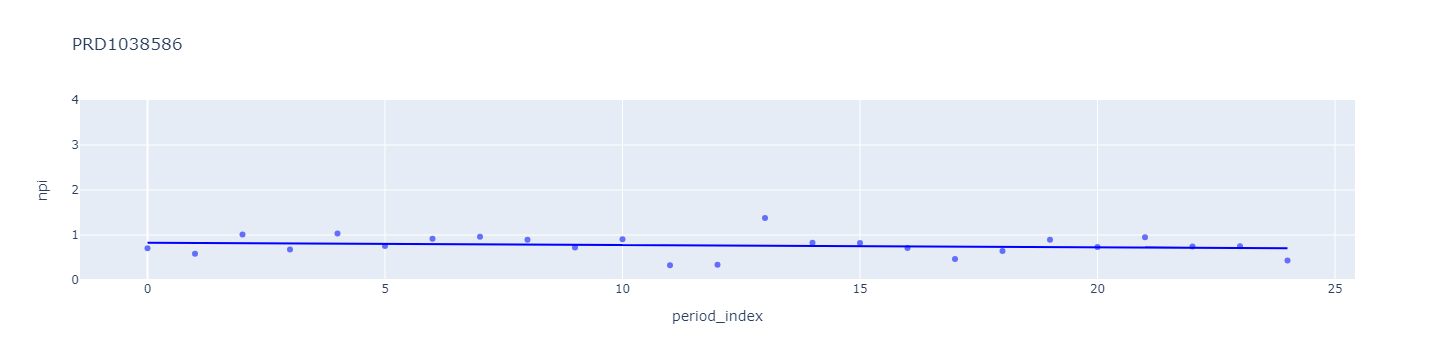

In [40]:
regression_scatterplot("PRD1038586", data_aggr_period_prod, regression_results)

## Product group level with aggregated regression

Coding the function to plot a scatter plot of the aggreated regression for a specified product group

In [41]:
def regression_prodgroup_aggr_scatterplot(productgroup, data_prod, prodgroup_results):
    data_aggr_period_prodgroup_loop = data_prod.loc[data_prod['product_group']== productgroup].sort_values('period').reset_index(drop=True)
    trace1 = px.scatter(data_aggr_period_prodgroup_loop, x = "period_index", y = "npi", title = productgroup)
    trace1.update_traces(marker=dict(color='red'))
    regression_results_filtered = prodgroup_results.loc[prodgroup_results['Product_Group'] == productgroup]
    intercept = regression_results_filtered['Intercept'].values[0]
    slope = regression_results_filtered['Slope'].values[0]
    df_prodgroup_line2 = pd.DataFrame()
    df_prodgroup_line2['x'] = data_aggr_period_prodgroup_loop["period_index"]
    df_prodgroup_line2['y'] = slope*df_prodgroup_line2['x']+intercept
    trace2 = px.line(df_prodgroup_line2, df_prodgroup_line2['x'], df_prodgroup_line2['y'], color_discrete_sequence=['red'])
    trace1.add_traces(list(trace2.select_traces()))
    trace1.update_layout(yaxis_range=[0,4])
    trace1.show()

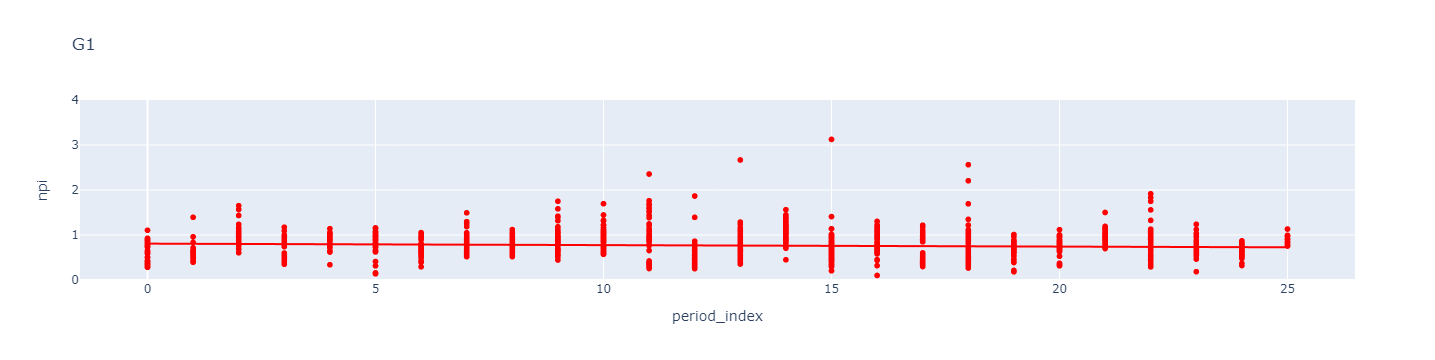

In [42]:
regression_prodgroup_aggr_scatterplot('G1', data_aggr_period_prod, regression_prodgroup_wls_results)

In [43]:
data['list_x_quantity'] = data.list_price * data.quantity
data['net_price_x_quantity'] = data.net_price * data.quantity

In [44]:
data['vol-weigh_avg_list'] = data['list_x_quantity']/data['quantity']

In [45]:
data['vol-weigh_avg_net'] = data['net_price_x_quantity']/data['quantity']

In [46]:
data['npi'] = data['vol-weigh_avg_net']/data['vol-weigh_avg_list']

In [47]:
data.head()

period     product product_group  quantity  list_price  net_price  \
1535   03/01/2020  PRD8624311            G1     18013    5.415827   5.206555   
11808  03/01/2020  PRD6766639            G3     24070    4.651561   4.614901   
11732  03/01/2020  PRD6766639            G3      5187    4.679885   4.746664   
6234   03/01/2020  PRD3823366            G1     81675    2.994978   1.842245   
11683  03/01/2020  PRD6766639            G3      2906    5.469381   5.417904   

       list_x_quantity  net_price_x_quantity  vol-weigh_avg_list  \
1535      97555.287450          93785.683837            5.415827   
11808    111963.074339         111080.674702            4.651561   
11732     24274.561620          24620.947869            4.679885   
6234     244614.800677         150465.353026            2.994978   
11683     15894.021803          15744.428560            5.469381   

       vol-weigh_avg_net       npi  
1535            5.206555  0.961359  
11808           4.614901  0.992119  
11732           4.746664  1.014270  
6234            1.842245  0.615111  
11683           5.417904  0.990588

## Product group level with unaggregated regression

Coding the function to plot a scatter plot of the unaggreated regression for a specified product group

In [48]:
def regression_prodgroup_notagg_scatterplot(productgroup, data_prod, prodgroup_results):
    data_aggr_period_prodgroup_loop = data_prod.loc[data_prod['product_group']== productgroup].sort_values('period').reset_index(drop=True)
    trace1 = px.scatter(data_aggr_period_prodgroup_loop, x = "period_index", y = "npi", title = productgroup)
    trace1.update_traces(marker=dict(color='red'))
    regression_results_filtered = prodgroup_results.loc[prodgroup_results['Product_Group'] == productgroup]
    intercept = regression_results_filtered['Intercept'].values[0]
    slope = regression_results_filtered['Slope'].values[0]
    df_prodgroup_line2 = pd.DataFrame()
    df_prodgroup_line2['x'] = data_aggr_period_prodgroup_loop["period_index"]
    df_prodgroup_line2['y'] = slope*df_prodgroup_line2['x']+intercept
    trace2 = px.line(df_prodgroup_line2, df_prodgroup_line2['x'], df_prodgroup_line2['y'], color_discrete_sequence=['red'])
    trace1.add_traces(list(trace2.select_traces()))
    trace1.update_layout(yaxis_range=[0,4])
    trace1.show()

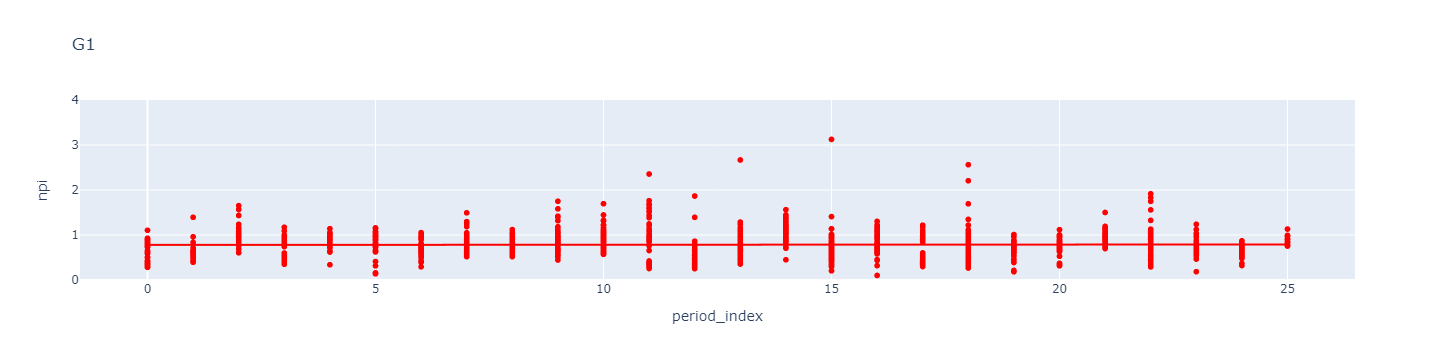

In [49]:
regression_prodgroup_notagg_scatterplot('G1', data_aggr_period_prod, regression_prodgroup_notagg_results)

## Product group level weighted-linear regression

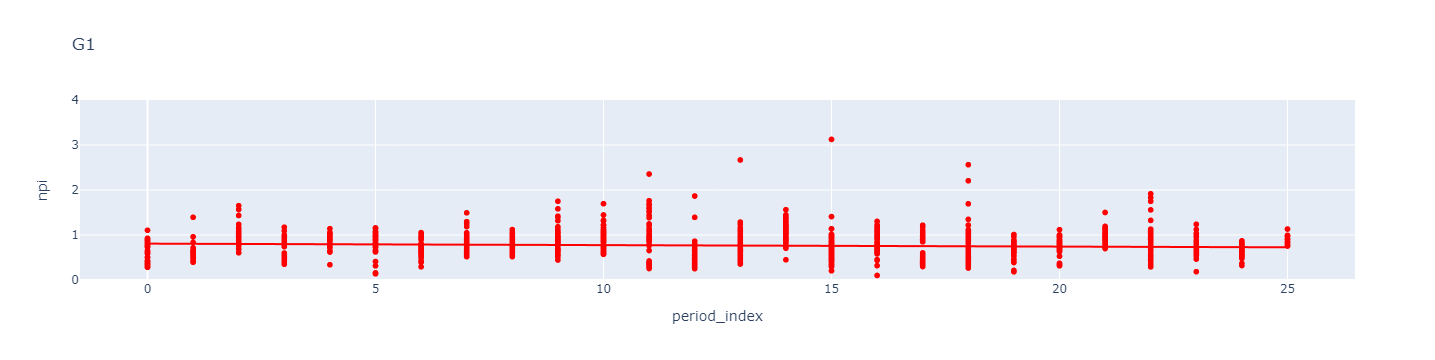

In [50]:
regression_prodgroup_notagg_scatterplot('G1', data_aggr_period_prod, regression_prodgroup_wls_results)

## Product level with product group regression

Coding the function to plot the scatter plot of each product with the product (blue) and product group regression (red)

In [51]:
def regression_prod_prodgroup_scatterplot(productname, data, reg_results, notagg_prodgroup_reg_results):
    data1 = data.loc[data['product']== productname].sort_values('period').reset_index(drop=True)
    prodgroup = data1['product_group'].values[0]
    trace1 = px.scatter(data1, x = "period_index", y = "npi", title = productname)
    trace1.update_traces(name='Original NPI', showlegend = True)
    trace1.update_traces(marker=dict(color='blue'))
    regression_results_filtered = reg_results.loc[reg_results['Product'] == productname]
    intercept = regression_results_filtered['Intercept'].values[0]
    slope = regression_results_filtered['Slope'].values[0]
    df_product_regress = pd.DataFrame()
    df_product_regress['x'] = data1["period_index"]
    df_product_regress['y'] = slope*df_product_regress['x']+intercept
    regression_prodgroup_results_filtered = notagg_prodgroup_reg_results.loc[notagg_prodgroup_reg_results['Product_Group'] == prodgroup]
    trace2 = px.line(df_product_regress, df_product_regress['x'], df_product_regress['y'], color_discrete_sequence=['blue'])
    trace2.update_traces(name='Unpooled Regression', showlegend = True)
    intercept2 = regression_prodgroup_results_filtered['Intercept'].values[0]
    slope2 = regression_prodgroup_results_filtered['Slope'].values[0]
    df_productgroup_regress = pd.DataFrame()
    df_productgroup_regress['x'] = data1["period_index"]
    df_productgroup_regress['y'] = slope2*df_productgroup_regress['x']+intercept2
    trace3 = px.line(df_productgroup_regress, df_productgroup_regress['x'], df_productgroup_regress['y'], color_discrete_sequence=['red'])
    trace3.update_traces(name='Pooled Regression', showlegend = True)
    trace4 = trace1.add_traces(list(trace2.select_traces()))
    trace5 = trace4.add_traces(list(trace3.select_traces()))
    trace5.update_layout(yaxis_range=[0.1,2])
    trace5.show()

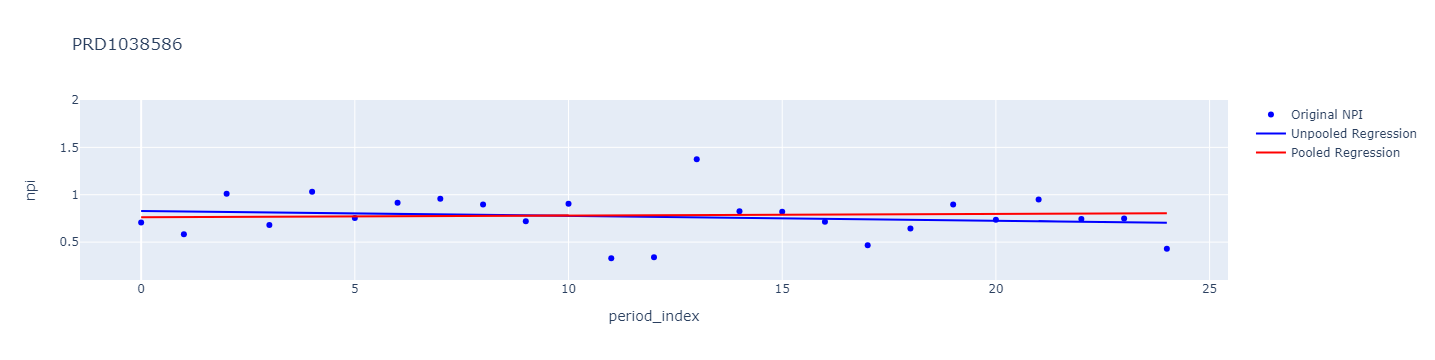

In [53]:
regression_prod_prodgroup_scatterplot('PRD1038586', data_aggr_period_prod, regression_results, regression_prodgroup_notagg_results)

## Every Product within a specified product group

Coding the function to plot a scatterplot for every product within a specified product group with the product (red) and product group regression (blue) lines

In [144]:
def prodgroup_plots(productgroup, data, reg_results, notagg_prodgroup_reg_results):
    data_period_prodgroup = data.loc[data['product_group']== productgroup].sort_values('period').reset_index(drop=True).reset_index(drop=True)
    productgroup_prod_array = data_period_prodgroup['product'].unique()
    for prod in productgroup_prod_array:
        data_aggr_period_prodgroup_prod_loop = data_period_prodgroup.loc[data_period_prodgroup['product']==prod].sort_values('period').reset_index(drop=True)
        trace1 = px.scatter(data_aggr_period_prodgroup_prod_loop, x = "period_index", y = "npi", title = prod)
        trace1.update_traces(name='Original NPI', showlegend = True)
        regression_results_filtered = reg_results.loc[reg_results['Product'] == prod]
        intercept = regression_results_filtered['Intercept'].values[0]
        slope = regression_results_filtered['Slope'].values[0]
        df_prod_regress = pd.DataFrame()
        df_prod_regress['x'] = data_aggr_period_prodgroup_prod_loop["period_index"]
        df_prod_regress['y'] = slope*df_prod_regress['x']+intercept
        trace2 = px.line(df_prod_regress, df_prod_regress['x'], df_prod_regress['y'],color_discrete_sequence=['blue'])
        trace2.update_traces(name='Unpooled Regression', showlegend = True)
        regression_prodgroup_results_filtered = notagg_prodgroup_reg_results.loc[notagg_prodgroup_reg_results['Product_Group'] == productgroup]
        intercept2 = regression_prodgroup_results_filtered['Intercept'].values[0]
        slope2 = regression_prodgroup_results_filtered['Slope'].values[0]
        df_prodgroup_regress = pd.DataFrame()
        df_prodgroup_regress['x'] = data_aggr_period_prodgroup_prod_loop["period_index"]
        df_prodgroup_regress['y'] = slope2*df_prod_regress['x']+intercept2
        trace3 = px.line(df_prodgroup_regress, df_prodgroup_regress['x'], df_prodgroup_regress['y'], color_discrete_sequence=['red'])
        trace3.update_traces(name='Pooled Regression', showlegend = True)
        trace4 = trace1.add_traces(list(trace2.select_traces()))
        trace5 = trace4.add_traces(list(trace3.select_traces())) 
        trace5.update_layout(yaxis_range=[0.1,2])
        trace5.show()

In [143]:
# example use of function 
#prodgroup_plots('G2', data_aggr_period_prod, regression_results, regression_prodgroup_notagg_results)

# Bayesian Regression

## MODEL 1) Normal prior assumption using product-level regresion OLS results

### Test for 1 product group

In [57]:
data_aggr_period_prod_BR = data_aggr_period_prod.copy()
data_aggr_period_prod_BR['x'] = data_aggr_period_prod_BR['period_index']
data_aggr_period_prod_BR['y'] = data_aggr_period_prod_BR['npi']
import pymc3 as pm
regression_results_BR = regression_results.copy()

In [58]:
# Test: for 1 productgrp
productgroup = 'G1'
bayesianmodel_dict1 = {}
trace_dict1 = {}
# Get the prior Normal parameters
regression_results_loop = regression_results_BR[regression_results_BR['Product_group']==productgroup]
data_aggr_period_prod_loop = data_aggr_period_prod_BR[data_aggr_period_prod_BR['product_group']==productgroup]
slope_mean = regression_results_loop[['Slope']].mean().values[0]
slope_std = regression_results_loop[['Slope']].std().values[0]
intercept_mean = regression_results_loop[['Intercept']].mean().values[0]
intercept_std = regression_results_loop[['Intercept']].std().values[0]

# Create bayesian model
with pm.Model() as bayesian_model_prod:
    slope = pm.Normal('slope', mu = slope_mean, sd = slope_std)
    intercept = pm.Normal('intercept', mu = intercept_mean, sd = intercept_std)
    #sigma = pm.Normal('sigma', mu = 0, sd = 1)

    # Linear regression line
    mean = intercept + slope*data_aggr_period_prod_loop['x']

    # Describe the distribution of our conditional output
    #y = pm.Normal('y', mu = mean, sd = sigma, observed = data_aggr_period_prod_BR['y']) # Run the sampling using pymc3 for 100 samples
    y = pm.Normal('y', mu = mean, observed = data_aggr_period_prod_loop['y']) # Run the sampling using pymc3 for 100 samples
    trace_100 = pm.sample(100,return_inferencedata=True)
bayesianmodel_dict1[productgroup] = bayesian_model_prod 
trace_dict1[productgroup] = trace_100 

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 608 seconds.
The acceptance probability does not match the target. It is 0.9034990346554682, but should be close to 0.8. Try to increase the number of tuning steps.


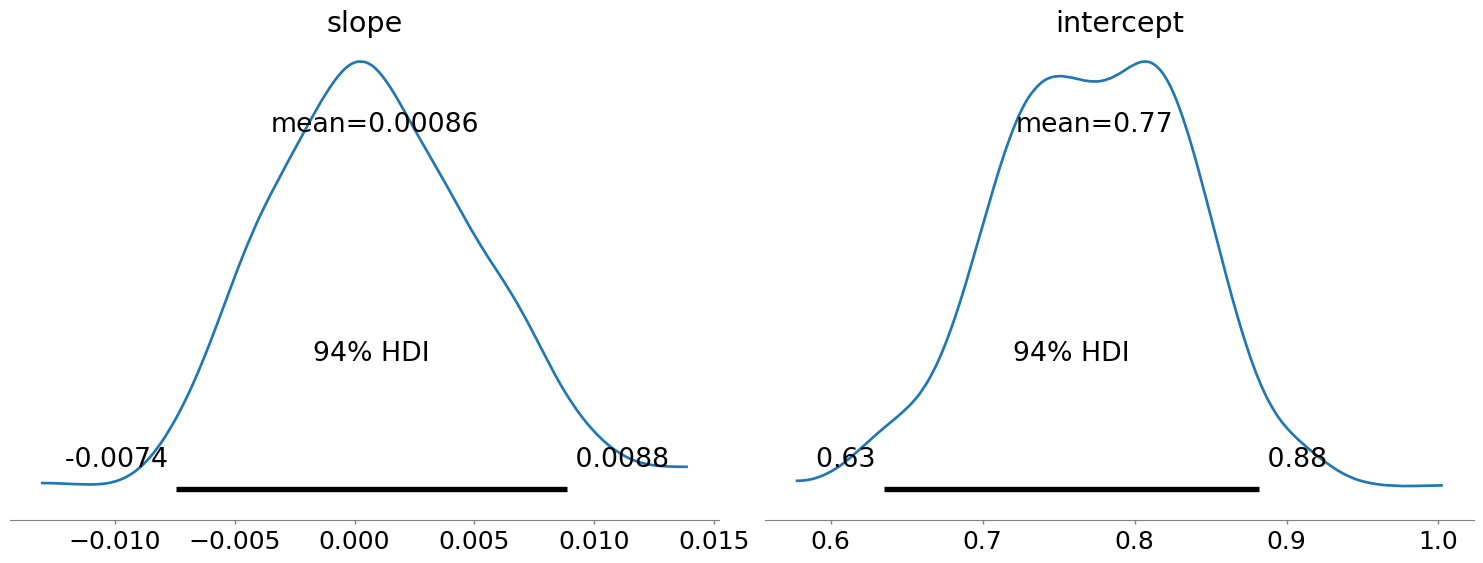

In [60]:
with bayesianmodel_dict1['G1']:
    az.plot_posterior(trace_dict1['G1'],
    var_names=['slope', 'intercept'], #,'sigma'],
    textsize=18,
    point_estimate='mean')

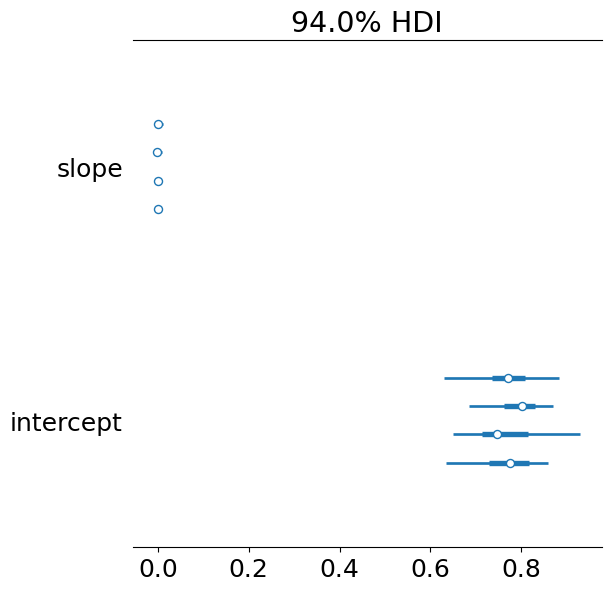

In [61]:
with bayesianmodel_dict1['G1']:
    az.plot_forest(trace_dict1['G1'],
    var_names=['slope', 'intercept'], #,'sigma'],
    textsize=18)

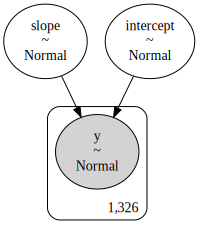

In [62]:
pm.model_to_graphviz(bayesianmodel_dict1['G1'])

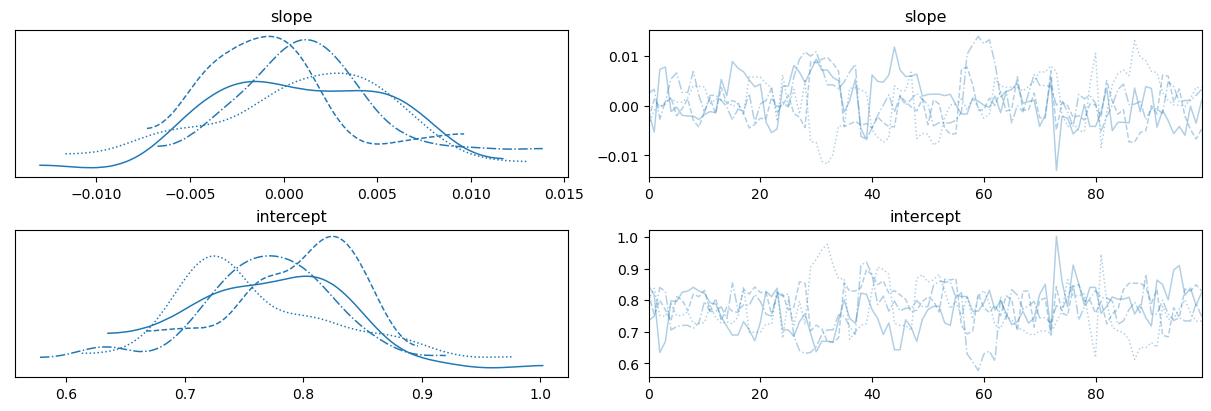

In [63]:
with bayesianmodel_dict1['G1']:
    az.plot_trace(trace_dict1['G1'],
        var_names=['slope', 'intercept']), #,'sigma'])

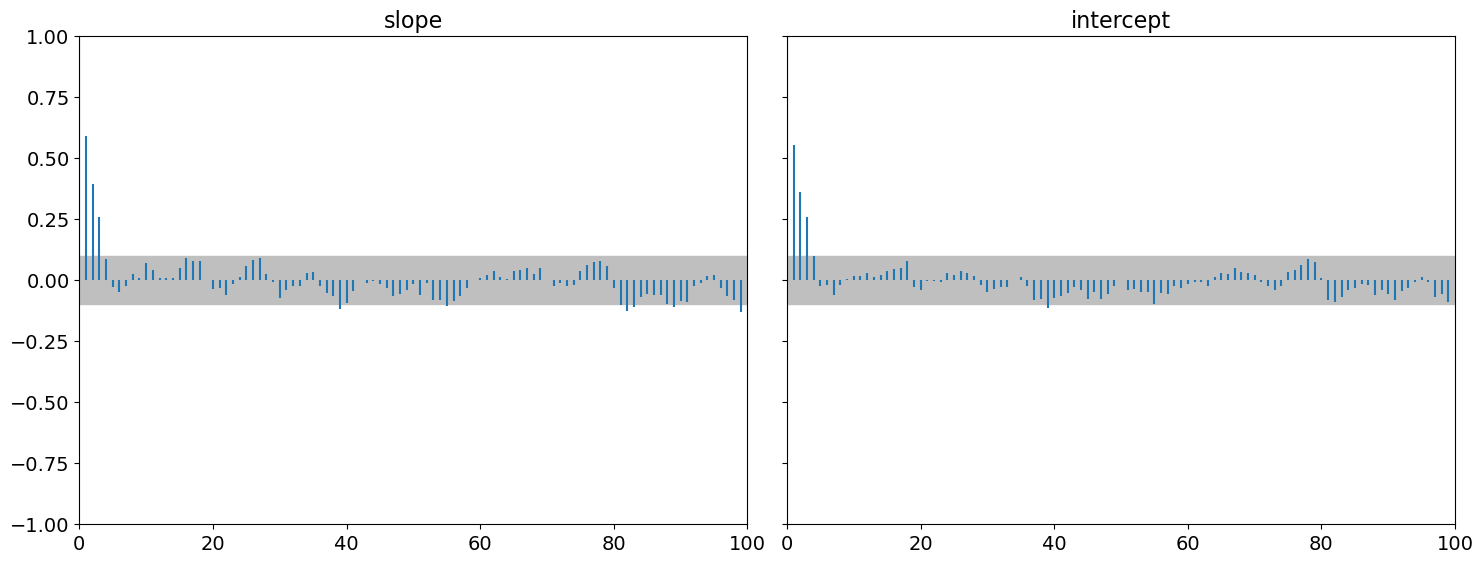

In [64]:
with bayesianmodel_dict1['G1']:
    az.plot_autocorr(trace_dict1['G1'],
                    combined = True)

### Generation for all product groups

In [65]:
# For loop all the productgroups
productgroup = 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10'
bayesian_fullmodel_dict = {}
trace_fullmodel_dict = {}
productgroup_prod_array = data_aggr_period_prod_BR['product_group'].unique()
for productgroup in productgroup_prod_array:
    # Get the prior Normal parameters
    regression_results_loop = regression_results_BR[regression_results_BR['Product_group']==productgroup]
    data_aggr_period_prod_loop = data_aggr_period_prod_BR[data_aggr_period_prod_BR['product_group']==productgroup]
    slope_mean = regression_results_BR[['Slope']].mean().values[0]
    slope_std = regression_results_BR[['Slope']].std().values[0]
    intercept_mean = regression_results_BR[['Intercept']].mean().values[0]
    intercept_std = regression_results_BR[['Intercept']].std().values[0]
 
    # Create bayesian model
    with pm.Model() as bayesian_model_allprod:
        slope = pm.Normal('slope', mu = slope_mean, sd = slope_std)
        intercept = pm.Normal('intercept', mu = intercept_mean, sd = intercept_std)
        #sigma = pm.Normal('sigma', mu = 0, sd = 1)

        # Linear regression line
        mean = intercept + slope*data_aggr_period_prod_loop['x']

        # Describe the distribution of our conditional output
        #y = pm.Normal('y', mu = mean, sd = sigma, observed = data_aggr_period_prod_BR['y']) # Run the sampling using pymc3 for 100 samples
        y = pm.Normal('y', mu = mean, observed = data_aggr_period_prod_loop['y']) # Run the sampling using pymc3 for 100 samples
        trace_105 = pm.sample(100,return_inferencedata=True)
    bayesian_fullmodel_dict[productgroup] = bayesian_model_allprod
    trace_fullmodel_dict[productgroup] = trace_105

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 174 seconds.
The acceptance probability does not match the target. It is 0.888445258056665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9003974989861863, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 749 seconds.
The acceptance probability does not match the target. It is 0.8836425546837385, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868244829838027, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9059878115568512, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 270 seconds.
The acceptance probability does not match the target. It is 0.8862530222388453, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [inter

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 188 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 118 seconds.
The acceptance probability does not match the target. It is 0.8852742366062937, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796223899491693, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 93 seconds.
The acceptance probability does not match the target. It is 0.8970396162623077, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.899513641318706, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess 

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 75 seconds.
The acceptance probability does not match the target. It is 0.8854045635984511, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012237148130348, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 60 seconds.
The acceptance probability does not match the target. It is 0.9045167319964275, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.905390644141672, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886357505457235, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8986939076763547, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 50 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 57 seconds.
The acceptance probability does not match the target. It is 0.8965620167934412, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


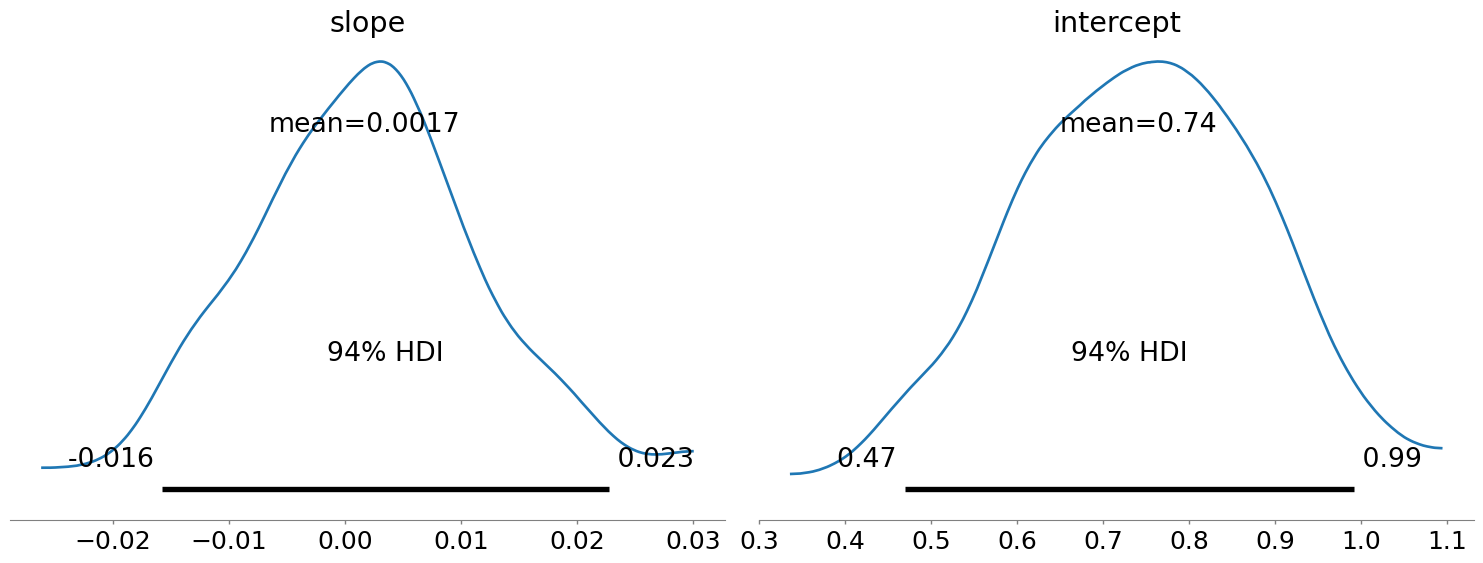

In [66]:
with bayesian_fullmodel_dict['G7']:
    az.plot_posterior(trace_fullmodel_dict['G7'],
    var_names=['slope', 'intercept'], #,'sigma'],
    textsize=18,
    point_estimate='mean')

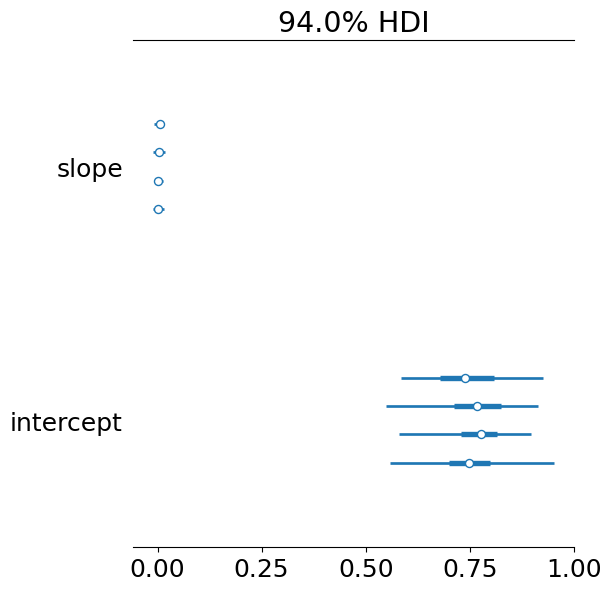

In [67]:
with bayesian_fullmodel_dict['G5']:
    az.plot_forest(trace_fullmodel_dict['G5'],
    var_names=['slope', 'intercept'], #,'sigma'],
    textsize=18)

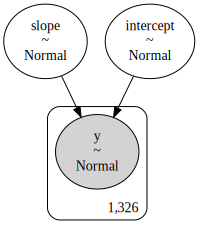

In [68]:
pm.model_to_graphviz(bayesian_fullmodel_dict['G1'])

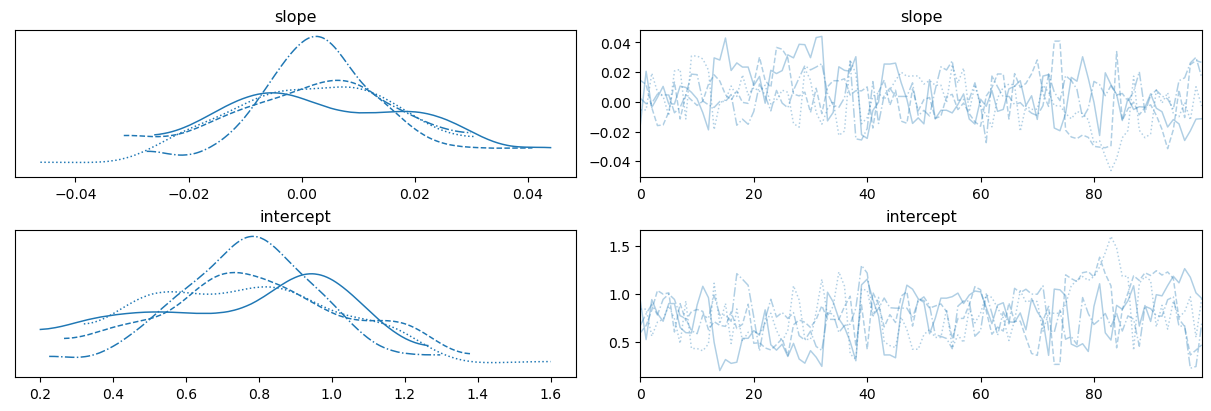

In [69]:
with bayesian_fullmodel_dict['G10']:
    az.plot_trace(trace_fullmodel_dict['G10'],
        var_names=['slope', 'intercept']), #,'sigma'])

#For loop each productgroup:
    Filter the dataframe of regression results of the 1st algorithm (pro-level) (regression_resuts)
    Filter the dtaframe of proct levelprice information (data_aggr_period_prod)
    Get mean() std() if slope
    Get mean() std() if intercept
    Create bayesian_model_prod (query below)
        add  those mand and std as input of bayesian regression
        use data_aggr_period_prod_filtered for data input
    Store bayesian_model_prod in a array/dictinary (append)

## MODEL 2) Uniform prior assumption using productgroup-level regresion OLS results

### Test for 1 product group

In [70]:
prodgroup ='G1'
data_aggr_period_prodgroup_loop = data_aggr_period_prod.loc[data_aggr_period_prod['product_group']==prodgroup].sort_values('period').reset_index(drop=True)
data_aggr_period_prodgroup_loop['x'] = np.array(data_aggr_period_prodgroup_loop['period_index'])
data_aggr_period_prodgroup_loop['y'] = np.array(data_aggr_period_prodgroup_loop['npi'])
formula = 'y ~ x'
results = smf.ols(formula, data=data_aggr_period_prodgroup_loop).fit()

In [71]:
# Start our model
prodgroup = 'G1'
bayesianmodel_dict2 = {}
trace_dict2 = {}

with pm.Model() as model_200: 
    # Define the priors on each parameter:
    grad = pm.Uniform("grad",
    lower=results.params['x']*0.5,
    upper=results.params['x']*1.5)

    inter = pm.Uniform("inter",
    lower=results.params['Intercept']*0.5,
    upper=results.params['Intercept']*1.5)

    sigma = pm.Uniform("sigma",
    lower=results.resid.std()*0.5,\
    upper=results.resid.std()*1.5)

    # Linear regression line
    mean = inter + grad*data_aggr_period_prodgroup_loop['x']

    # Describe the distribution of our conditional output
    y = pm.Normal('y', mu = mean, sd = sigma, observed = data_aggr_period_prodgroup_loop['y']) # Run the sampling using pymc3 for 100 samples
    trace_200 = pm.sample(100,return_inferencedata=True)
bayesianmodel_dict2[prodgroup] = model_200 
trace_dict2[prodgroup] = trace_200 

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, inter, grad]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 762 seconds.


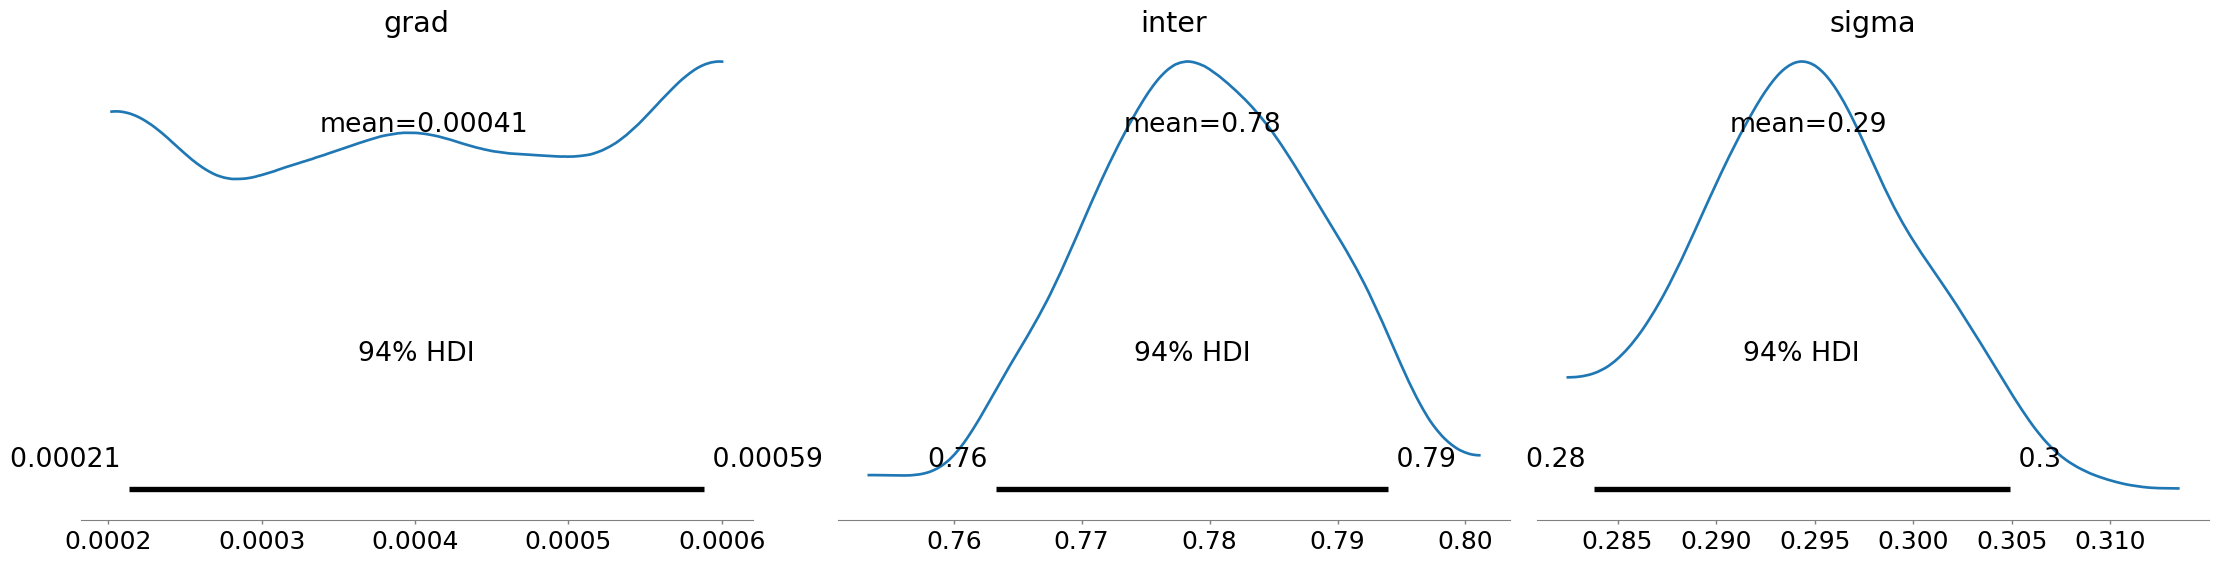

In [72]:
with bayesianmodel_dict2['G1']:
    az.plot_posterior(trace_dict2['G1'],
    var_names=['grad', 'inter', 'sigma'],
    textsize=18,
    point_estimate='mean')

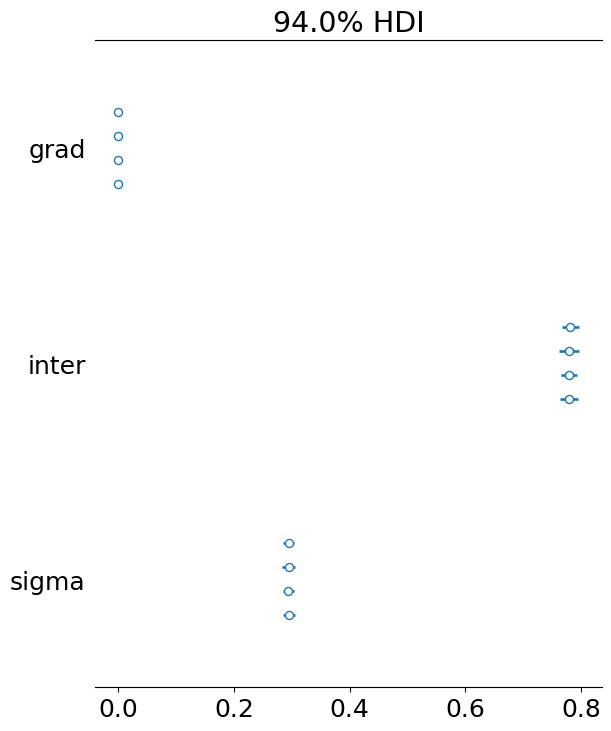

In [73]:
with bayesianmodel_dict2['G1']:
    az.plot_forest(trace_dict2['G1'],
    var_names=['grad', 'inter', 'sigma'],
    textsize=18)

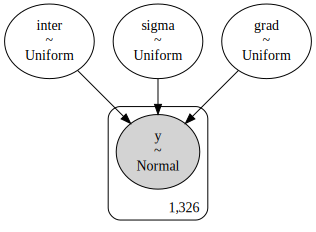

In [74]:
pm.model_to_graphviz(bayesianmodel_dict2['G1'])

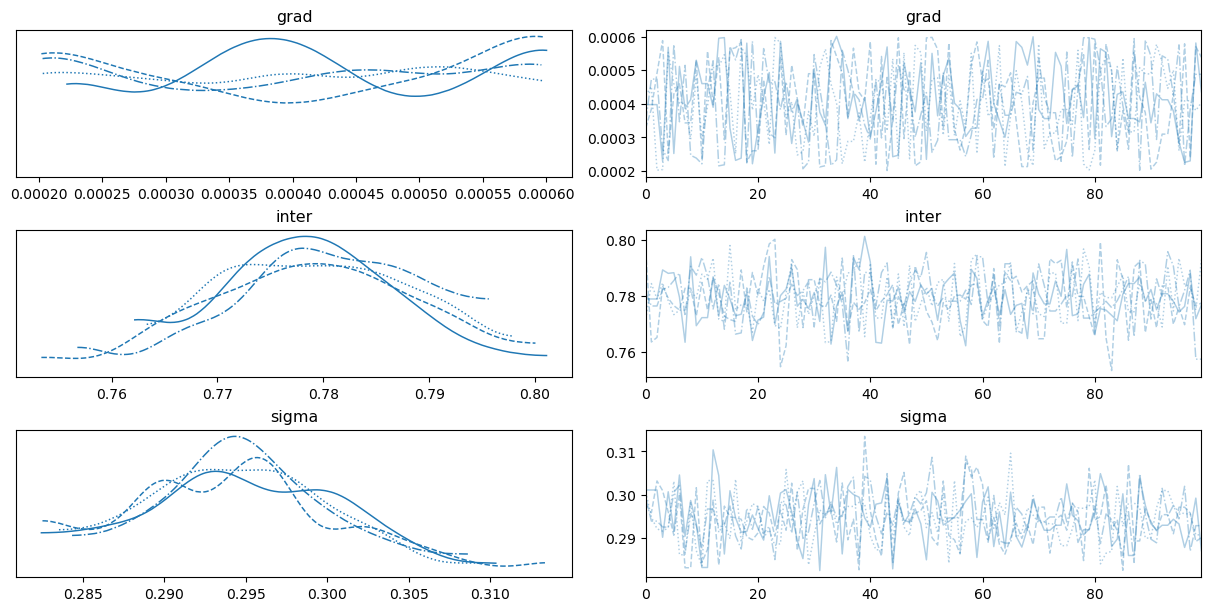

In [75]:
with bayesianmodel_dict2['G1']:
    az.plot_trace(trace_dict2['G1'],
        var_names=['grad', 'inter', 'sigma'])

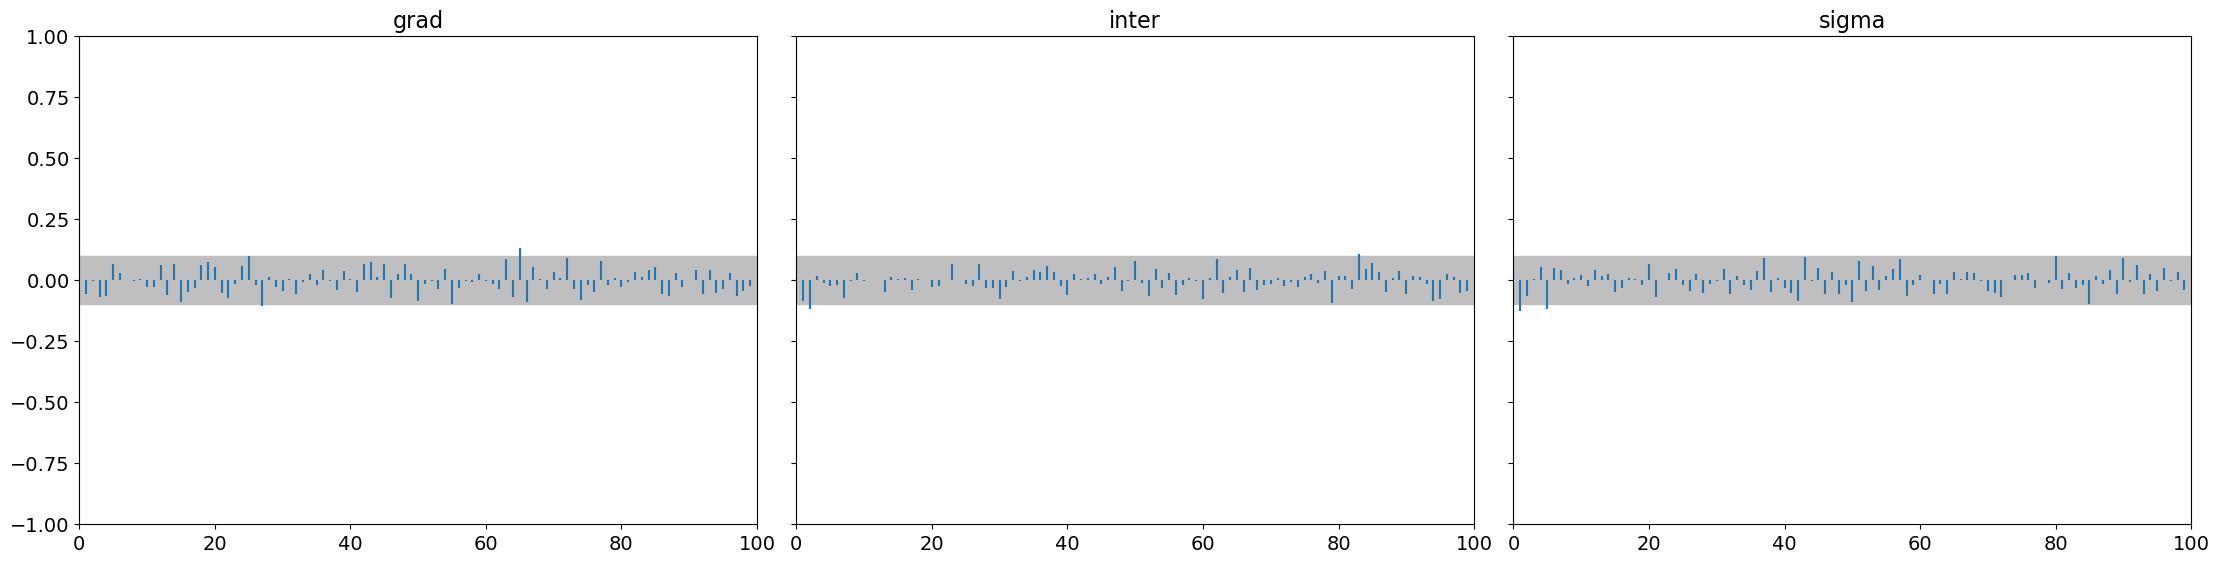

In [77]:
with bayesianmodel_dict2['G1']:
    az.plot_autocorr(trace_dict2['G1'],
                    combined = True)

### Generation for all product groups

In [78]:
for prodgroup in productgroup_array:
    data_aggr_period_prodgroup_loop = data_aggr_period_prod.loc[data_aggr_period_prod['product_group']==prodgroup].sort_values('period').reset_index(drop=True)
    if len(data_aggr_period_prodgroup_loop) > 1:
        data_aggr_period_prodgroup_loop['x'] = np.array(data_aggr_period_prodgroup_loop['period_index'])
        data_aggr_period_prodgroup_loop['y'] = np.array(data_aggr_period_prodgroup_loop['npi'])
        formula = 'y ~ x'
        results = smf.ols(formula, data=data_aggr_period_prodgroup_loop).fit()
        results.resid

## Bayesian Regression at product level

In [79]:
def f_bayesian_reg_prod(product):
    productgroup = regression_results_BR[regression_results_BR['Product']==product]['Product_group'].values[0]
    bayesianmodel_dict3 = {}
    trace_dict3 = {}
    # Get the prior Normal parameters
    regression_results_loop = regression_results_BR[regression_results_BR['Product_group']==productgroup]
    data_aggr_period_prod_loop = data_aggr_period_prod_BR[data_aggr_period_prod_BR['product']==product]
    slope_mean = regression_results_loop[['Slope']].mean().values[0]
    slope_std = regression_results_loop[['Slope']].std().values[0]
    intercept_mean = regression_results_loop[['Intercept']].mean().values[0]
    intercept_std = regression_results_loop[['Intercept']].std().values[0]

    # Create bayesian model
    with pm.Model() as bayesian_model_prod3:
        slope = pm.Normal('slope', mu = slope_mean, sd = slope_std)
        intercept = pm.Normal('intercept', mu = intercept_mean, sd = intercept_std)
        #sigma = pm.Normal('sigma', mu = 0, sd = 1)

        # Linear regression line
        mean = intercept + slope*data_aggr_period_prod_loop['x']

        # Describe the distribution of our conditional output
        #y = pm.Normal('y', mu = mean, sd = sigma, observed = data_aggr_period_prod_BR['y']) # Run the sampling using pymc3 for 100 samples
        y = pm.Normal('y', mu = mean, observed = data_aggr_period_prod_loop['y']) # Run the sampling using pymc3 for 100 samples
        trace_100 = pm.sample(100,return_inferencedata=True)
    bayesianmodel_dict3[product] = bayesian_model_prod3
    trace_dict3[product] = trace_100 
    return bayesianmodel_dict3, trace_dict3

In [80]:
def regression_vs_bayesian_prod_scatterplot(productname, data, reg_results, bayesian_reg_dict_results):
    data1 = data.loc[data['product']== productname].sort_values('period').reset_index(drop=True)
    #prodgroup = data1['product_group'].values[0]
    trace1 = px.scatter(data1, x = "period_index", y = "npi", title = productname)
    trace1.update_traces(name='Original NPI', showlegend = True)
    trace1.update_traces(marker=dict(color='blue'))
    regression_results_filtered = reg_results.loc[reg_results['Product'] == productname]
    intercept = regression_results_filtered['Intercept'].values[0]
    slope = regression_results_filtered['Slope'].values[0]
    df_product_regress = pd.DataFrame()
    df_product_regress['x'] = data1["period_index"]
    df_product_regress['y'] = slope*df_product_regress['x']+intercept
    bayesian_reg_results_filtered = pm.summary(bayesian_reg_dict_results[productname])
    trace2 = px.line(df_product_regress, df_product_regress['x'], df_product_regress['y'], color_discrete_sequence=['blue'])
    trace2.update_traces(name='Ordinary Regression', showlegend = True)
    intercept2 = bayesian_reg_results_filtered['mean'].loc['intercept']
    slope2 = bayesian_reg_results_filtered['mean'].loc['slope']
    df_productgroup_regress = pd.DataFrame()
    df_productgroup_regress['x'] = data1["period_index"]
    df_productgroup_regress['y'] = slope2*df_productgroup_regress['x']+intercept2
    trace3 = px.line(df_productgroup_regress, df_productgroup_regress['x'], df_productgroup_regress['y'], color_discrete_sequence=['purple'])
    trace3.update_traces(name='Bayesian Regression', showlegend = True)
    trace4 = trace1.add_traces(list(trace2.select_traces()))
    trace5 = trace4.add_traces(list(trace3.select_traces()))
    trace5.update_layout(yaxis_range=[0.1,2])
    trace5.show()

### EXAMPLE 1) Example of product with good number of observations (prod group G1)

In [91]:
product1 = 'PRD1054424'

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.


Bayesian regression results


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope      -0.0  0.021  -0.037    0.039      0.002    0.001     111.0   
intercept   0.8  0.299   0.300    1.318      0.027    0.019     122.0   

           ess_tail  r_hat  
slope         124.0   1.02  
intercept     119.0   1.01

Linear regression results


Product Product_group     Slope  Intercept    Rvalue    Pvalue
0  PRD1054424            G1 -0.000732   0.802915 -0.016123  0.939027

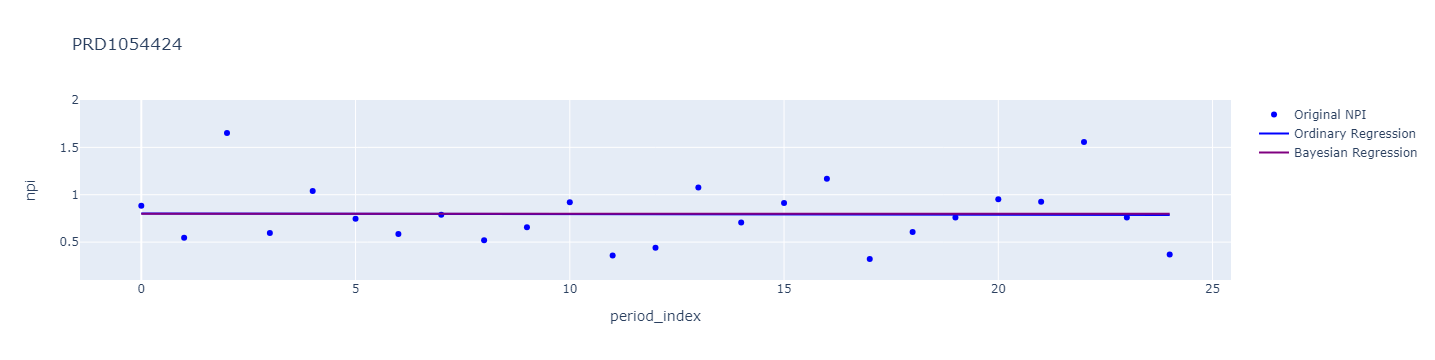

In [92]:
bayesianmodel_dict_prod1, trace_dict_prod1 = f_bayesian_reg_prod(product1)
bayesian_results = pm.summary(trace_dict_prod1[product1])
print('Bayesian regression results')
display(bayesian_results)
regression_results_prod1 = regression_results_BR[regression_results_BR['Product']==product1]
print('Linear regression results')
display(regression_results_prod1)
regression_vs_bayesian_prod_scatterplot(product1, data_aggr_period_prod_BR, regression_results_BR, trace_dict_prod1)

### Exmaple 2) Good number of observations (prod group G8)

In [83]:
product2 = 'PRD9875757'

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 29 seconds.


Bayesian regression results


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope      0.000  0.020  -0.034    0.045      0.002    0.001     120.0   
intercept  0.762  0.321   0.182    1.353      0.030    0.022     113.0   

           ess_tail  r_hat  
slope         127.0   1.01  
intercept     124.0   1.02

Linear regression results


Product Product_group     Slope  Intercept    Rvalue    Pvalue
0  PRD9875757            G8  0.003545   0.698414  0.103879  0.645485

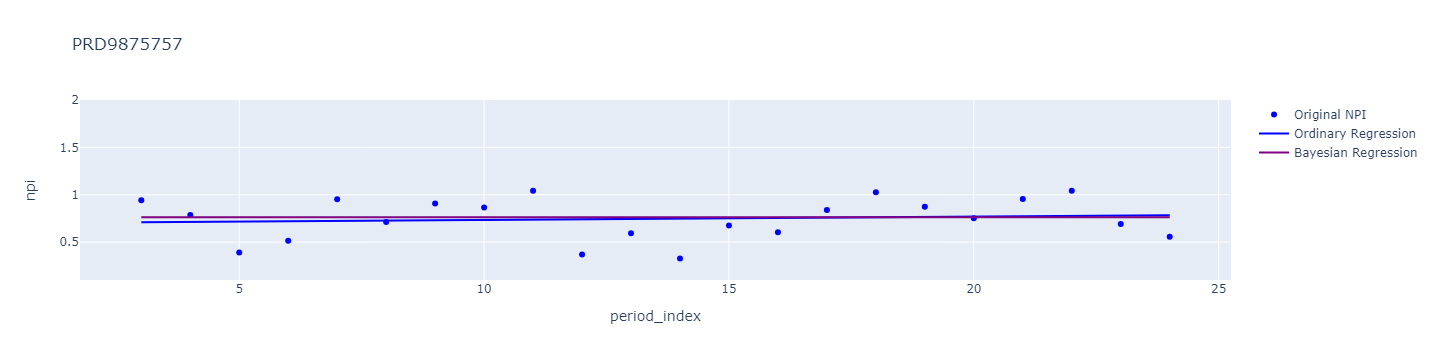

In [84]:
bayesianmodel_dict_prod2, trace_dict_prod2 = f_bayesian_reg_prod(product2)
bayesian_results = pm.summary(trace_dict_prod2[product2])
print('Bayesian regression results')
display(bayesian_results)
regression_results_prod2 = regression_results_BR[regression_results_BR['Product']==product2]
print('Linear regression results')
display(regression_results_prod2) 
regression_vs_bayesian_prod_scatterplot(product2, data_aggr_period_prod_BR, regression_results_BR, trace_dict_prod2)

### EXAMPLE 3) Few observations (prod group G8)

In [85]:
product3 = 'PRD1767300'

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8801991820304707, but should be close to 0.8. Try to increase the number of tuning steps.


Bayesian regression results


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope      0.004  0.033  -0.062    0.063      0.002    0.002     178.0   
intercept  0.855  0.503  -0.140    1.679      0.040    0.028     162.0   

           ess_tail  r_hat  
slope         184.0   1.03  
intercept     113.0   1.02

Linear regression results


Product Product_group     Slope  Intercept    Rvalue    Pvalue
0  PRD1767300            G8  0.064732    0.07518  0.793068  0.206932

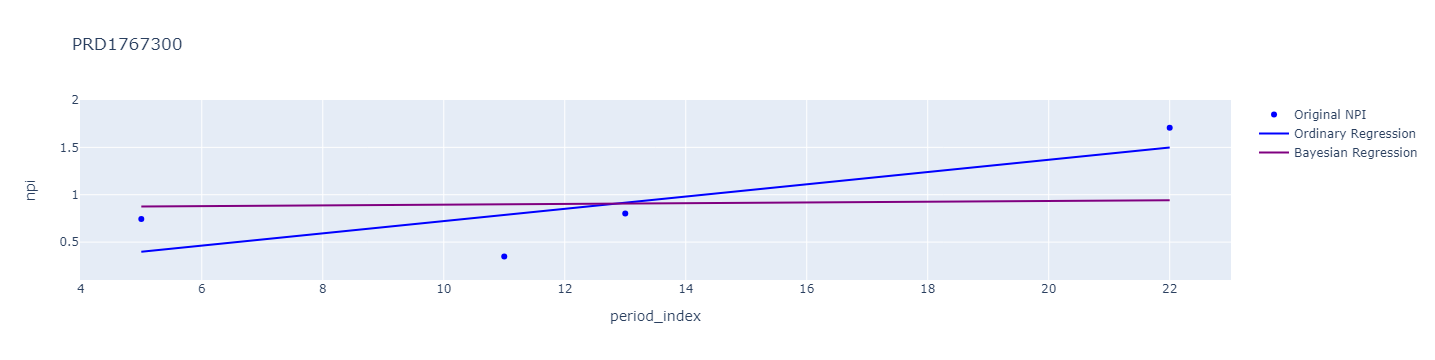

In [86]:
bayesianmodel_dict_prod3, trace_dict_prod3 = f_bayesian_reg_prod(product3)
bayesian_results = pm.summary(trace_dict_prod3[product3])
print('Bayesian regression results')
display(bayesian_results)
regression_results_prod3 = regression_results_BR[regression_results_BR['Product']==product3]
print('Linear regression results')
display(regression_results_prod3) 
regression_vs_bayesian_prod_scatterplot(product3, data_aggr_period_prod_BR, regression_results_BR, trace_dict_prod3)

### EXAMPLE 4) Few observations (prod group G1)

In [93]:
product4 = 'PRD8040451'

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.


Bayesian regression results


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope      0.003  0.029  -0.062    0.049      0.002    0.002     165.0   
intercept  0.743  0.584  -0.314    1.873      0.043    0.031     183.0   

           ess_tail  r_hat  
slope         155.0   1.02  
intercept     280.0   1.02

Linear regression results


Product Product_group     Slope  Intercept    Rvalue    Pvalue
0  PRD8040451            G1 -0.180095   4.864973 -0.856543  0.143457

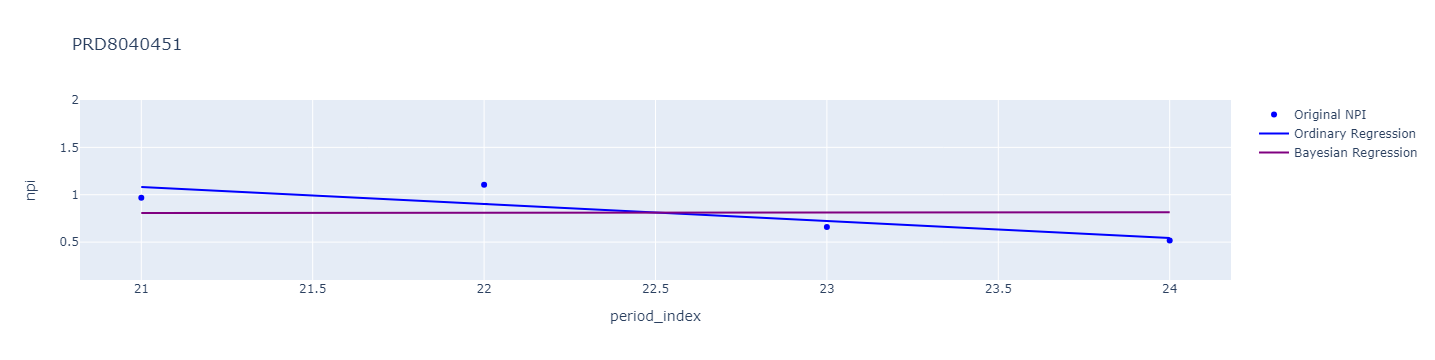

In [94]:
bayesianmodel_dict_prod4, trace_dict_prod4 = f_bayesian_reg_prod(product4)
bayesian_results = pm.summary(trace_dict_prod4[product4])
print('Bayesian regression results')
display(bayesian_results)
regression_results_prod4 = regression_results_BR[regression_results_BR['Product']==product4]
print('Linear regression results')
display(regression_results_prod4)
regression_vs_bayesian_prod_scatterplot(product4, data_aggr_period_prod_BR, regression_results_BR, trace_dict_prod4)

# Summary of % products trending same directing or opposite comparing regression and bayesian

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.8964460759453854, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8956516715358859, but should be close to 0.8. Try to increase the number of tuning steps.


Bayesian regression results


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope      0.004  0.019  -0.031    0.039      0.002    0.001     133.0   
intercept  0.705  0.294   0.195    1.285      0.026    0.020     138.0   

           ess_tail  r_hat  
slope         188.0   1.02  
intercept     146.0   1.03

Linear regression results


Product Product_group     Slope  Intercept    Rvalue    Pvalue
0  PRD6766639            G3  0.005141   0.701636  0.139161  0.497775

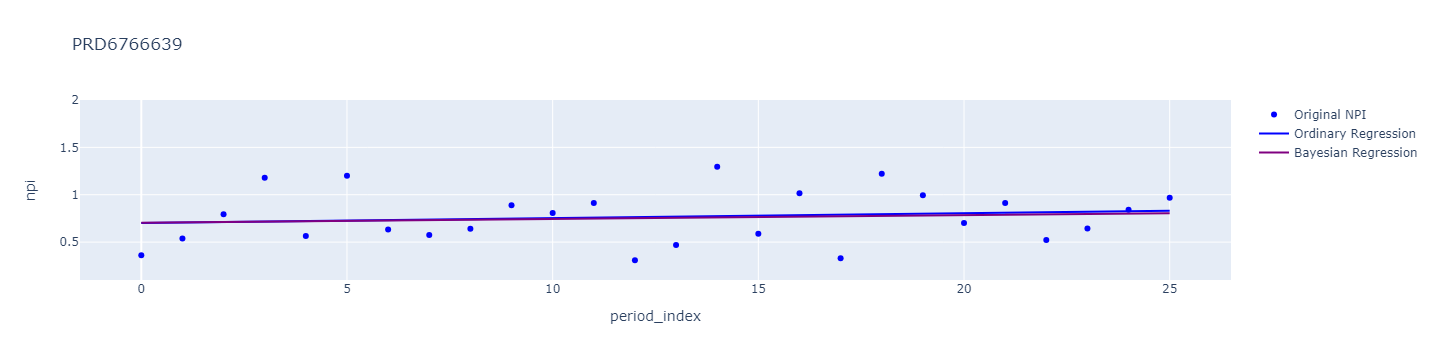

In [96]:
product = 'PRD6766639'
bayesianmodel_dict_prod1, trace_dict_prod1 = f_bayesian_reg_prod(product)
bayesian_results = pm.summary(trace_dict_prod1[product])
print('Bayesian regression results')
display(bayesian_results)
regression_results_prod1 = regression_results_BR[regression_results_BR['Product']==product]
print('Linear regression results')
display(regression_results_prod1)
regression_vs_bayesian_prod_scatterplot(product, data_aggr_period_prod_BR, regression_results_BR, trace_dict_prod1)

## Using a single product

In [97]:
product_example = 'PRD6766639'
bayesianmodel_dict_prodlevel = {}
trace_dict_prodlevel = {}
bayesian_model_prodlevel, trace_prodlevel = f_bayesian_reg_prod(product_example)
bayesianmodel_dict_prodlevel = bayesian_model_prodlevel
trace_dict_prodlevel = trace_prodlevel

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 30 seconds.


In [98]:
product_example = 'PRD6766639'
prod_results = pm.summary(trace_dict_prodlevel[product_example])
regression_results_prod1 = regression_results_BR[regression_results_BR['Product']==product_example]

In [99]:
prod_results

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
slope      0.004  0.016  -0.023    0.036      0.001    0.001     171.0   
intercept  0.702  0.262   0.237    1.166      0.020    0.014     168.0   

           ess_tail  r_hat  
slope         227.0   1.01  
intercept     154.0   1.01

In [100]:
regression_results_prod1

Product Product_group     Slope  Intercept    Rvalue    Pvalue
0  PRD6766639            G3  0.005141   0.701636  0.139161  0.497775

In [101]:
prod_results_df = pd.DataFrame(columns = ['product', 'slope_mean', 'slope_sd', 'int_mean', 'int_sd', 'olr_slope', 'olr_int'])

In [102]:
prod_results_df

Empty DataFrame
Columns: [product, slope_mean, slope_sd, int_mean, int_sd, olr_slope, olr_int]
Index: []

In [103]:
append_data = pd.DataFrame({'product': [product_example], 'slope_mean': [prod_results.iloc[0,0]], 'slope_sd': [prod_results.iloc[0,1]], 'int_mean': [prod_results.iloc[1,0]], 'int_sd': [prod_results.iloc[1,1]], 'olr_slope': [regression_results_prod1.iloc[0,2]], 'olr_int': [regression_results_prod1.iloc[0,3]]})

# append the new DataFrame to the existing DataFrame
prod_results_df = pd.concat([prod_results_df,append_data])

In [104]:
prod_results_df

product  slope_mean  slope_sd  int_mean  int_sd  olr_slope   olr_int
0  PRD6766639       0.004     0.016     0.702   0.262   0.005141  0.701636

In [105]:
prod_results_df['bayes_slope_dir'] = np.where(prod_results_df['slope_mean'] < -0.025, 'negative', 
                                              (np.where(prod_results_df['slope_mean'] > 0.025, 'positive', 'neutral')))
prod_results_df['olr_slope_dir'] = np.where(prod_results_df['slope_mean'] < -0.025, 'negative', 
                                              (np.where(prod_results_df['slope_mean'] > 0.025, 'positive', 'neutral')))

In [106]:
prod_results_df['slope_dir_comparison'] = np.where(prod_results_df['bayes_slope_dir'] == prod_results_df['olr_slope_dir'], 'same_direction', 'different_direction')
prod_results_df

product  slope_mean  slope_sd  int_mean  int_sd  olr_slope   olr_int  \
0  PRD6766639       0.004     0.016     0.702   0.262   0.005141  0.701636   

  bayes_slope_dir olr_slope_dir slope_dir_comparison  
0         neutral       neutral       same_direction

## Follow-up topics

### Step 0. Concatenation of bayesian results and liner regression results for comparison

In [107]:
product_array = regression_results_BR['Product'].unique()

In [108]:
bayesianmodel_dict_prodlevel1 = {}
trace_dict_prodlevel1 = {}
product_array = regression_results_BR['Product'].unique()
print(len(product_array))
for product in product_array:
    print(product)
    bayesian_model_prodlevel1, trace_prodlevel1 = f_bayesian_reg_prod(product)
    #bayesianmodel_dict_prodlevel1[product] = bayesian_model_prodlevel1
    bayesianmodel_dict_prodlevel1.update(bayesian_model_prodlevel1)
    #trace_dict_prodlevel1[product] = trace_prodlevel1
    trace_dict_prodlevel1.update(trace_prodlevel1)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


211
PRD1038586


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1054424


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 29 seconds.
The number of effective samples is smaller than 25% for some parameters.


PRD1117782


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.8983336943655967, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1188242


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.886227876021161, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1205396


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8912150399807728, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1273611


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8944565627674445, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1384064


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.9041152262223084, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1489543


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.8963879641445157, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.889329830709039, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1577586


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8867905186789002, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1653775


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1672659


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1697626


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8795663713065639, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1763918


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1801660


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8866115134227318, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7023557001623424, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1834847


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1960529


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.


PRD1977633


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8800577583315317, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1987717


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8939649574633077, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2051939


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8864003232402673, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8976406099507848, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2111189


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2262514


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8816395448240509, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2305269


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2490456


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8890533481117694, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8828508127398565, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2491164


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2532691


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2763410


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8953088219020144, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2800022


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8918986624079206, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2929974


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3011692


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 29 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3086554


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
The acceptance probability does not match the target. It is 0.8831596418890922, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3228432


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8937599993454802, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3348826


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3492956


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3497573


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3526034


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 23 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3529812


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.9047198242655133, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8991067060852798, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3583935


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3615380


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8997425646915447, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3632804


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3767336


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8951680379147631, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3823366


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8803623947214055, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8851796643084495, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3919558


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8822421039340655, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4028594


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8792686627038222, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9083135770088642, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4090330


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8853594234074592, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4186991


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8949600096836376, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795698707591127, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4192338


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.7137776382693849, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4220563


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8977083750706863, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4228438


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4228743


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.9128291080540724, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4377560


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4424197


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4434152


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4578303


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4720306


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.915765534774324, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4809877


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8860581321475063, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802189953691485, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9031299380198042, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5056666


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.9084976830547398, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5064569


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5265217


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5270441


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5318613


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5330551


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8941521877613922, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5416762


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5557239


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8905986984944265, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5600677


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8891718158599605, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861119995776023, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8997781409007709, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5673170


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8834565118168554, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5682374


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8888804542228851, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5708549


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5826944


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


PRD5878793


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8861378751535599, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5895984


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8869111251370808, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867776178288161, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5926826


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5939149


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8826191702224037, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5950066


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8821288541382212, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5967271


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5995136


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.881095101536963, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6032096


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.9013887438693122, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6260297


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.9048547773712204, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6349834


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 23 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6401470


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6419132


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 23 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6453384


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8794178096415188, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6542347


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6601827


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.888142498114578, but should be close to 0.8. Try to increase the number of tuning steps.


PRD6609463


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6663883


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6766639


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.88377039403739, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9006904707147301, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6833557


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8860004786986521, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8925567131875688, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8949193846249726, but should be close to 0.8. Try to increase the number of tuning steps.


PRD6876780


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6889722


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6997061


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8830801900052161, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.911369087595744, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7001938


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7044819


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7085612


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8955105395649084, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7171628


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8991858740625014, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7181260


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8972744653928258, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7206256


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8958366556045405, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859423253397248, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8970391927418795, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7208565


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8913169289926625, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.897881870603231, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7222712


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7226059


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7299195


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.9019007234513157, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7362682


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8849989024564302, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7418165


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7521074


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7560367


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8879248678040184, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8953567883454342, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7573299


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7597222


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8794927436881206, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846087514614124, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7610179


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8791667765967834, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7636292


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8839907996160702, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9108692833479094, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8330872


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8452207


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8808429551183624, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8624311


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8999086949322783, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8960871


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8938408172039783, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9041586542893012, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8993838


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.7028026792648957, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.904946412127901, but should be close to 0.8. Try to increase the number of tuning steps.


PRD9176653


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8806348463961542, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867282691968462, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9196716


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8884449917584191, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928868781391622, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9236625


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 29 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9250892


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9267270


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8908354425109231, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9276760


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9348274


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9470407


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9545829


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8799136937250609, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9633124


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9652704


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8829914521940176, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9655862


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9697682


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.7154340228244476, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8801797190869055, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9872855


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9875757


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 29 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9930387


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.898179952059572, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8814480089233677, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9972628


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8868773719769201, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9994664


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8832010386876423, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1013401


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8966028368701713, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1691437


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8869328360461434, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829494672252696, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1724886


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1767300


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1880748


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.7148044719623275, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849349492128379, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837110842531516, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1931828


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8827411862989062, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863949350607965, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8819116747324182, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2295921


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8955499498628606, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9155844457909815, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890400327155908, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2729445


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8812969900627833, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3185153


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.9106721606211815, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9159754701236325, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3261220


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3548074


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8939455412883206, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4372480


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 26 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4554198


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.9011968400014173, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9037107232219469, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4941266


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8946879202196881, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5015272


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8824858402283516, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6123150


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.899590402639578, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8786998686143597, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6213678


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6523924


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8825404375520735, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6563278


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8879760728903406, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6850709


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6898168


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7096401


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7380364


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7683970


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7741589


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7954655


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8842686616820852, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8040451


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8793690837941655, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794631836688762, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8184587


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8934111480315924, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870649607702832, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8241910


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8814187163396676, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8986360937669867, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8574489


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8952191281229344, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8688668


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8805703734945078, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9341694


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.9038012975400194, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2405335


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.9058528151476692, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2995419


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8841003318537982, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3485724


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4084508


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4392488


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8814523370562288, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4481922


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.895881599202565, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886276254815558, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9052787020468271, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5030572


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 17 seconds.


PRD6009221


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8847639659669766, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892879947057021, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6166106


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7302939


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8816753595538226, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7443603


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7481789


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8543736


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8877960442651142, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9639357


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1015891


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1197151


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8983480353045291, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3399764


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5894435


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8862221


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


PRD9176976


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9202142


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8792266810767554, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2750455


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4676166


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6048073


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 17 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7505157


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8827281974727764, but should be close to 0.8. Try to increase the number of tuning steps.


PRD8809545


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9082137


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 17 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9171142


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD9750075


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8908631268667108, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3006933


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4492766


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8884278411950929, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4509293


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.881589942769849, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5446450


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9114865583697055, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9100467465078527, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8980917659913501, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5855617


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD5976973


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4034250


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD4707646


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8865509490394701, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD8238759


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6122853


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8821698186320872, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6461288


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3019823


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1263034


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 17 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD1351091


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD6605928


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 19 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD7304827


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3798956


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD2766760


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8853820689076747, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


PRD3300363


C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply

C:\Users\bismah.ghafoor\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in log

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 18 seconds.


In [109]:
#create new dataframe 
allprod_results_df = pd.DataFrame(columns = ['product', 'product_group', 'slope_mean', 'slope_sd', 
                                                 'int_mean', 'int_sd', 
                                                 'olr_slope', 'olr_int'])

for product in product_array:
    #retreive the bayesian and olr results for the product
    allprod_results = pm.summary(trace_dict_prodlevel1[product])
    regression_results_allprod = regression_results_BR[regression_results_BR['Product']==product]
    Product_group = regression_results_allprod['Product_group'].values[0]
    # append the new DataFrame to the existing DataFrame
    append_data_allprods = pd.DataFrame({'product': [product],
                                         'product_group': [Product_group],
                                         'slope_mean': [allprod_results.iloc[0,0]], 
                                         'slope_sd': [allprod_results.iloc[0,1]], 
                                         'int_mean': [allprod_results.iloc[1,0]], 
                                         'int_sd': [allprod_results.iloc[1,1]], 
                                         'olr_slope': [regression_results_allprod.iloc[0,2]], 
                                         'olr_int': [regression_results_allprod.iloc[0,3]]})

    allprod_results_df = pd.concat([allprod_results_df, append_data_allprods]).reset_index(drop = True)


In [110]:
allprod_results_df

product product_group  slope_mean  slope_sd  int_mean  int_sd  \
0    PRD1038586            G5       0.006     0.014     0.687   0.181   
1    PRD1054424            G1      -0.000     0.022     0.805   0.299   
2    PRD1117782            G3       0.004     0.018     0.787   0.276   
3    PRD1188242            G9      -0.000     0.032     0.754   0.451   
4    PRD1205396            G9       0.002     0.029     0.714   0.410   
..          ...           ...         ...       ...       ...     ...   
206  PRD6605928            G1       0.005     0.035     0.728   0.448   
207  PRD7304827            G3       0.006     0.027     0.840   0.462   
208  PRD3798956            G5       0.009     0.024     0.688   0.186   
209  PRD2766760            G2      -0.010     0.024     0.982   0.390   
210  PRD3300363            G2      -0.010     0.026     0.986   0.380   

     olr_slope   olr_int  
0    -0.005159  0.829078  
1    -0.000732  0.802915  
2     0.002505  0.788040  
3     0.005845  0.654496  
4     0.001330  0.725618  
..         ...       ...  
206   0.041227  0.242302  
207   0.006813  0.998302  
208   0.081863  0.128128  
209   0.027116  0.634062  
210  -0.025234  1.083120  

[211 rows x 8 columns]

## find the no. of observations

### Step 1. Label comparison

Analyze distribution of slope to find the caps to label direction

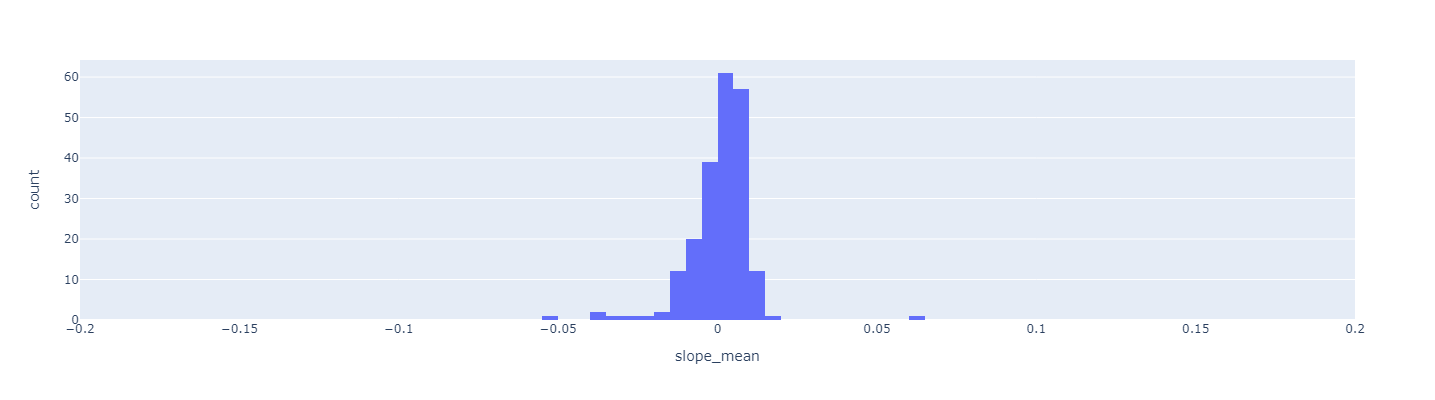

In [111]:
bin_width= 0.005          
nbins = math.ceil((allprod_results_df["slope_mean"].max() - allprod_results_df["slope_mean"].min()) / bin_width)
fig = px.histogram(allprod_results_df, x='slope_mean', nbins = nbins, height = 400, range_x =(-0.2, 0.2))
fig.show()

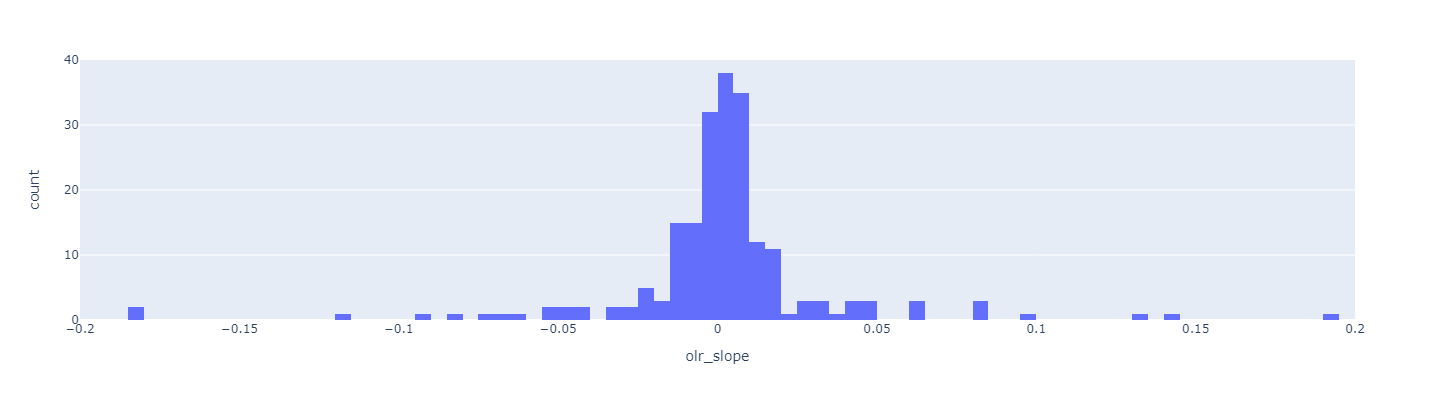

In [112]:
bin_width= 0.005           
nbins = math.ceil((allprod_results_df["olr_slope"].max() - allprod_results_df["olr_slope"].min()) / bin_width)
fig = px.histogram(allprod_results_df, x='olr_slope', nbins = nbins, height = 400, range_x =(-0.2, 0.2))
fig.show()

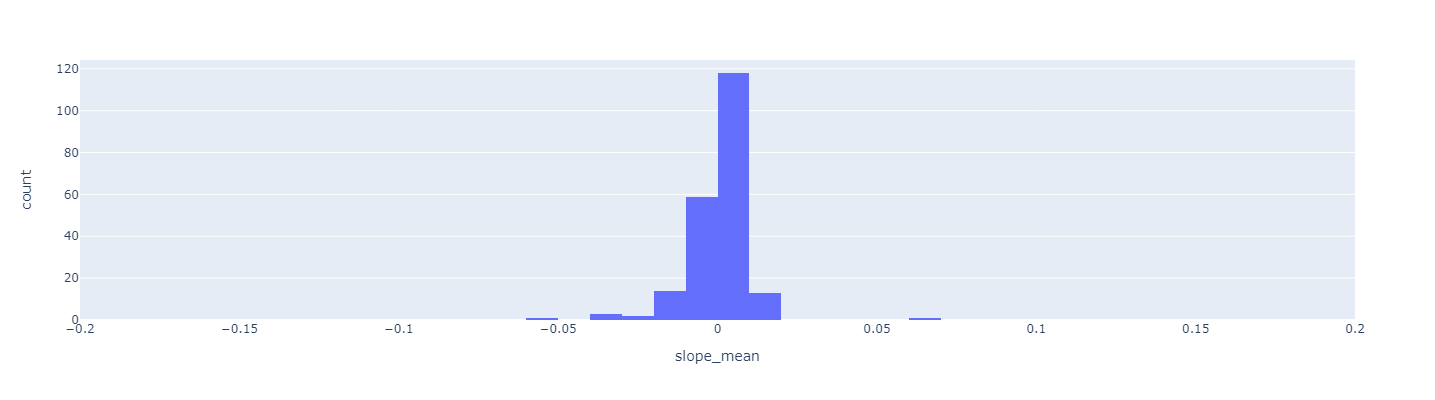

In [113]:
fig = px.histogram(allprod_results_df, x='slope_mean', nbins = 20, height = 400, range_x =(-0.2, 0.2))
fig.show()

In [114]:
#create the new columns for dataframe
allprod_results_df['bayes_slope_dir'] = np.where(allprod_results_df['slope_mean'] < -0.025, 'negative', 
                                              (np.where(allprod_results_df['slope_mean'] > 0.025, 'positive', 
                                                        'neutral')))
allprod_results_df['olr_slope_dir'] = np.where(allprod_results_df['olr_slope'] < -0.025, 'negative', 
                                              (np.where(allprod_results_df['olr_slope'] > 0.025, 'positive', 
                                                        'neutral')))
allprod_results_df['slope_dir_comparison'] = np.where(allprod_results_df['bayes_slope_dir'] == allprod_results_df['olr_slope_dir'], 
                                                      'same_direction', 'different_direction')

In [115]:
allprod_results_df

product product_group  slope_mean  slope_sd  int_mean  int_sd  \
0    PRD1038586            G5       0.006     0.014     0.687   0.181   
1    PRD1054424            G1      -0.000     0.022     0.805   0.299   
2    PRD1117782            G3       0.004     0.018     0.787   0.276   
3    PRD1188242            G9      -0.000     0.032     0.754   0.451   
4    PRD1205396            G9       0.002     0.029     0.714   0.410   
..          ...           ...         ...       ...       ...     ...   
206  PRD6605928            G1       0.005     0.035     0.728   0.448   
207  PRD7304827            G3       0.006     0.027     0.840   0.462   
208  PRD3798956            G5       0.009     0.024     0.688   0.186   
209  PRD2766760            G2      -0.010     0.024     0.982   0.390   
210  PRD3300363            G2      -0.010     0.026     0.986   0.380   

     olr_slope   olr_int bayes_slope_dir olr_slope_dir slope_dir_comparison  
0    -0.005159  0.829078         neutral       neutral       same_direction  
1    -0.000732  0.802915         neutral       neutral       same_direction  
2     0.002505  0.788040         neutral       neutral       same_direction  
3     0.005845  0.654496         neutral       neutral       same_direction  
4     0.001330  0.725618         neutral       neutral       same_direction  
..         ...       ...             ...           ...                  ...  
206   0.041227  0.242302         neutral      positive  different_direction  
207   0.006813  0.998302         neutral       neutral       same_direction  
208   0.081863  0.128128         neutral      positive  different_direction  
209   0.027116  0.634062         neutral      positive  different_direction  
210  -0.025234  1.083120         neutral      negative  different_direction  

[211 rows x 11 columns]

In [116]:
same_count = allprod_results_df['slope_dir_comparison'].value_counts()
same_count

same_direction         169
different_direction     42
Name: slope_dir_comparison, dtype: int64

In [120]:
df_agg_prod = data_aggr_period_prod.groupby('product').count().reset_index()
df_agg_prod = df_agg_prod[['period','product']]
df_agg_prod = df_agg_prod.rename(columns = {'period':'rows'})
df_agg_prod

rows     product
0       1  PRD1000516
1       5  PRD1013401
2       3  PRD1015891
3      25  PRD1038586
4       1  PRD1038792
..    ...         ...
218    26  PRD9872855
219    22  PRD9875757
220    24  PRD9930387
221    20  PRD9972628
222    24  PRD9994664

[223 rows x 2 columns]

In [121]:
'''df_agg_prod = df_agg_prod[['period','product']]
df_agg_prod = df_agg_prod.rename(columns = {'period':'rows'})
df_agg_prod'''

"df_agg_prod = df_agg_prod[['period','product']]\ndf_agg_prod = df_agg_prod.rename(columns = {'period':'rows'})\ndf_agg_prod"

In [122]:
allprod_results_df_left = allprod_results_df.merge(df_agg_prod, on = 'product')

In [123]:
allprod_results_df_left

product product_group  slope_mean  slope_sd  int_mean  int_sd  \
0    PRD1038586            G5       0.006     0.014     0.687   0.181   
1    PRD1054424            G1      -0.000     0.022     0.805   0.299   
2    PRD1117782            G3       0.004     0.018     0.787   0.276   
3    PRD1188242            G9      -0.000     0.032     0.754   0.451   
4    PRD1205396            G9       0.002     0.029     0.714   0.410   
..          ...           ...         ...       ...       ...     ...   
206  PRD6605928            G1       0.005     0.035     0.728   0.448   
207  PRD7304827            G3       0.006     0.027     0.840   0.462   
208  PRD3798956            G5       0.009     0.024     0.688   0.186   
209  PRD2766760            G2      -0.010     0.024     0.982   0.390   
210  PRD3300363            G2      -0.010     0.026     0.986   0.380   

     olr_slope   olr_int bayes_slope_dir olr_slope_dir slope_dir_comparison  \
0    -0.005159  0.829078         neutral       neutral       same_direction   
1    -0.000732  0.802915         neutral       neutral       same_direction   
2     0.002505  0.788040         neutral       neutral       same_direction   
3     0.005845  0.654496         neutral       neutral       same_direction   
4     0.001330  0.725618         neutral       neutral       same_direction   
..         ...       ...             ...           ...                  ...   
206   0.041227  0.242302         neutral      positive  different_direction   
207   0.006813  0.998302         neutral       neutral       same_direction   
208   0.081863  0.128128         neutral      positive  different_direction   
209   0.027116  0.634062         neutral      positive  different_direction   
210  -0.025234  1.083120         neutral      negative  different_direction   

     rows  
0      25  
1      25  
2      26  
3      19  
4      25  
..    ...  
206     4  
207     2  
208     2  
209     2  
210     2  

[211 rows x 12 columns]

In [124]:
allprod_results_df_left['no_obs'] = np.where(allprod_results_df_left['rows']>=10, '>=10', '<10')
stats_df = allprod_results_df_left.groupby(['no_obs','slope_dir_comparison']).count().reset_index()
stats_df = stats_df[['no_obs','slope_dir_comparison','product']]
stats_df

no_obs slope_dir_comparison  product
0    <10  different_direction       38
1    <10       same_direction       29
2   >=10  different_direction        4
3   >=10       same_direction      140

#### Stats summary table

In [125]:
allprod_results_df_summary_prodgrp = allprod_results_df.groupby(['product_group', 'slope_dir_comparison']).size().reset_index()
allprod_results_df_summary_prodgrp.rename(columns = {0:'count'}, inplace = True)
allprod_results_df_summary_prodgrp

product_group slope_dir_comparison  count
0             G1  different_direction     17
1             G1       same_direction     67
2            G10  different_direction      2
3            G10       same_direction      4
4             G2  different_direction      6
5             G2       same_direction     15
6             G3  different_direction      7
7             G3       same_direction     22
8             G4       same_direction      3
9             G5  different_direction      3
10            G5       same_direction     19
11            G6       same_direction      7
12            G7  different_direction      2
13            G7       same_direction      9
14            G8  different_direction      3
15            G8       same_direction      4
16            G9  different_direction      2
17            G9       same_direction     19

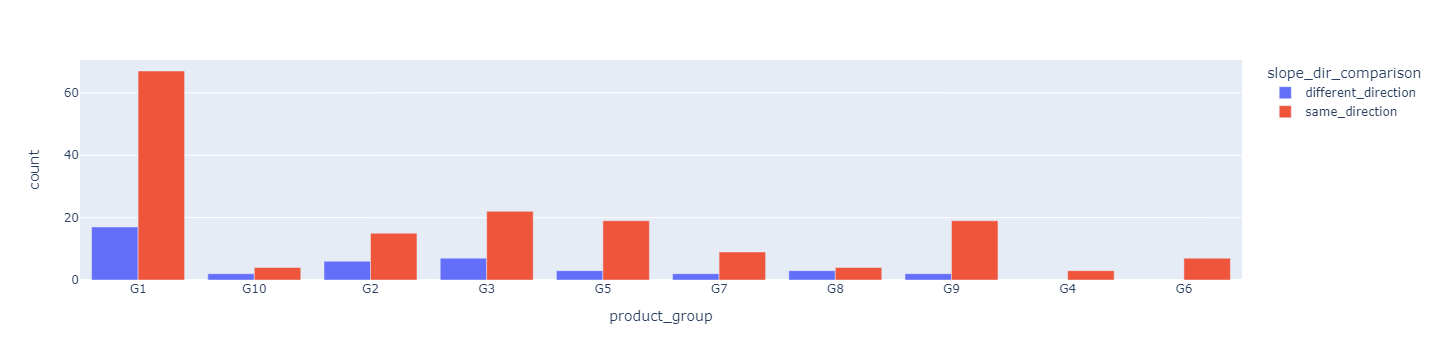

In [126]:
prdgrp_summary = px.bar(allprod_results_df_summary_prodgrp, x = "product_group", y = "count", 
             color = "slope_dir_comparison", barmode = "group")
prdgrp_summary

In [127]:
allprod_results_df_summary = allprod_results_df.groupby(['slope_dir_comparison']).size().reset_index()
allprod_results_df_summary.rename(columns = {0:'count'}, inplace = True)
allprod_results_df_summary

slope_dir_comparison  count
0  different_direction     42
1       same_direction    169

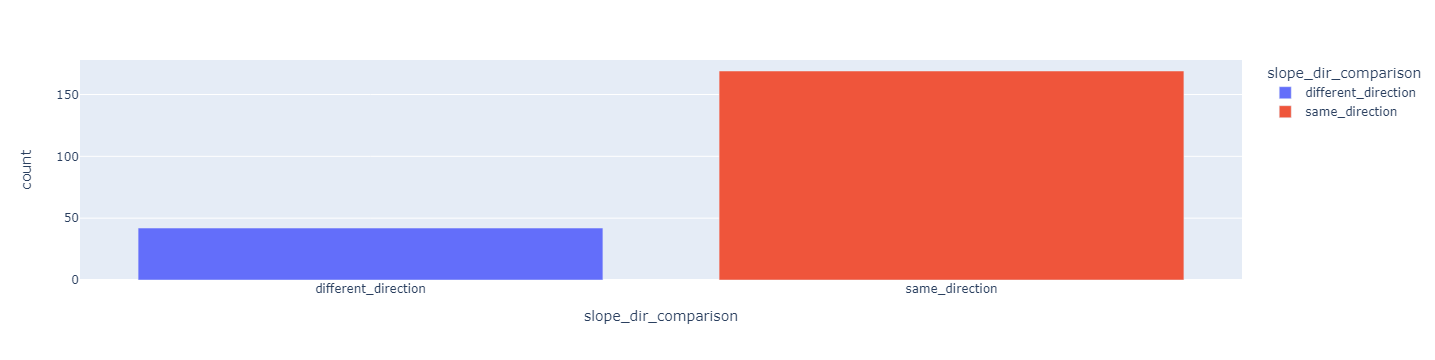

In [128]:
product_summary = px.bar(allprod_results_df_summary, x = "slope_dir_comparison", y = "count", color = "slope_dir_comparison")
product_summary

### Difference-wise comparison

Create metrics

In [129]:
allprod_results_df['absolute_difference'] = allprod_results_df['olr_slope'] - allprod_results_df['slope_mean']
allprod_results_df['%_difference'] = allprod_results_df['absolute_difference']/allprod_results_df['olr_slope']

In [130]:
allprod_results_df

product product_group  slope_mean  slope_sd  int_mean  int_sd  \
0    PRD1038586            G5       0.006     0.014     0.687   0.181   
1    PRD1054424            G1      -0.000     0.022     0.805   0.299   
2    PRD1117782            G3       0.004     0.018     0.787   0.276   
3    PRD1188242            G9      -0.000     0.032     0.754   0.451   
4    PRD1205396            G9       0.002     0.029     0.714   0.410   
..          ...           ...         ...       ...       ...     ...   
206  PRD6605928            G1       0.005     0.035     0.728   0.448   
207  PRD7304827            G3       0.006     0.027     0.840   0.462   
208  PRD3798956            G5       0.009     0.024     0.688   0.186   
209  PRD2766760            G2      -0.010     0.024     0.982   0.390   
210  PRD3300363            G2      -0.010     0.026     0.986   0.380   

     olr_slope   olr_int bayes_slope_dir olr_slope_dir slope_dir_comparison  \
0    -0.005159  0.829078         neutral       neutral       same_direction   
1    -0.000732  0.802915         neutral       neutral       same_direction   
2     0.002505  0.788040         neutral       neutral       same_direction   
3     0.005845  0.654496         neutral       neutral       same_direction   
4     0.001330  0.725618         neutral       neutral       same_direction   
..         ...       ...             ...           ...                  ...   
206   0.041227  0.242302         neutral      positive  different_direction   
207   0.006813  0.998302         neutral       neutral       same_direction   
208   0.081863  0.128128         neutral      positive  different_direction   
209   0.027116  0.634062         neutral      positive  different_direction   
210  -0.025234  1.083120         neutral      negative  different_direction   

     absolute_difference  %_difference  
0              -0.011159      2.162988  
1              -0.000732      1.000000  
2              -0.001495     -0.596659  
3               0.005845      1.000000  
4              -0.000670     -0.503940  
..                   ...           ...  
206             0.036227      0.878720  
207             0.000813      0.119340  
208             0.072863      0.890060  
209             0.037116      1.368790  
210            -0.015234      0.603705  

[211 rows x 13 columns]

Plot historgrams to analyze differce between OLR and Bayes results

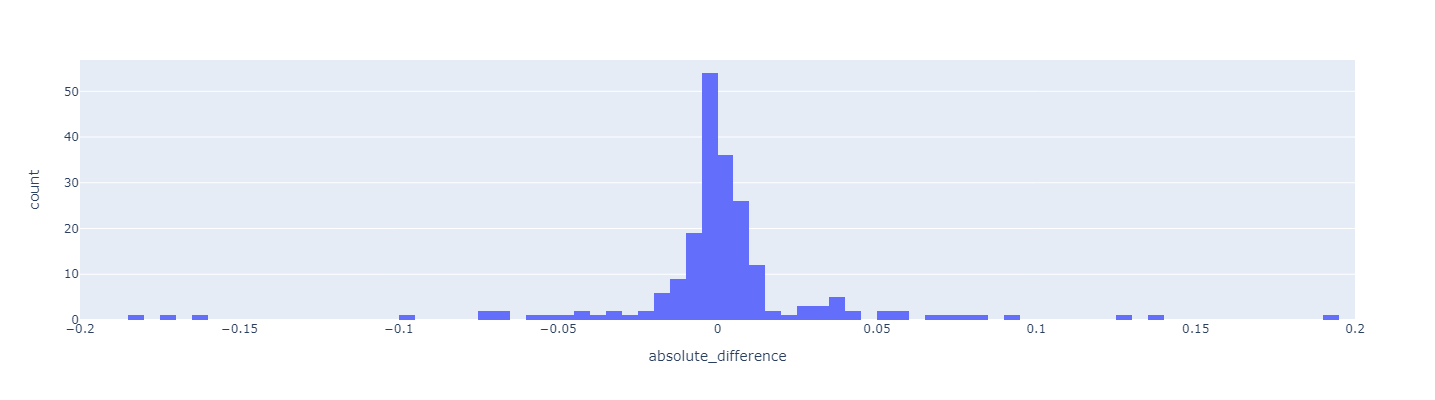

In [131]:
bin_width= 0.005           
nbins = math.ceil((allprod_results_df["absolute_difference"].max() - allprod_results_df["absolute_difference"].min()) / bin_width)
fig = px.histogram(allprod_results_df, x='absolute_difference', nbins = nbins, facet_col_wrap = 3, height = 400, range_x =(-0.2, 0.2))
fig.show()

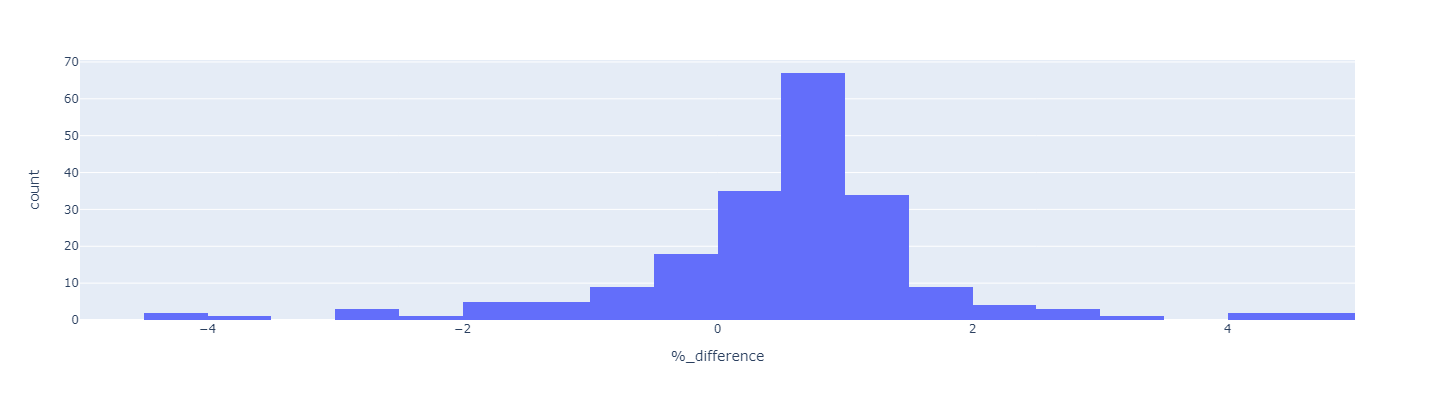

In [132]:
bin_width= 0.5           
nbins = math.ceil((allprod_results_df["%_difference"].max() - allprod_results_df["%_difference"].min()) / bin_width)
fig = px.histogram(allprod_results_df, x='%_difference', nbins = nbins, facet_col_wrap = 3, height = 400, range_x =(-5, 5))
fig.show()

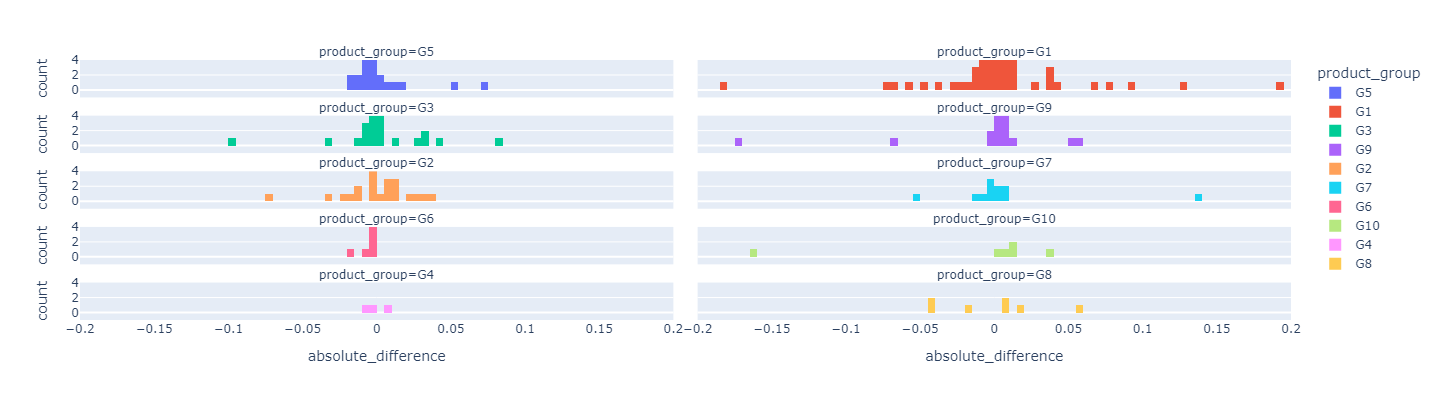

In [133]:
bin_width= 0.005           
nbins = math.ceil((allprod_results_df["absolute_difference"].max() - allprod_results_df["absolute_difference"].min()) / bin_width)
fig = px.histogram(allprod_results_df, x='absolute_difference', nbins = nbins, color = 'product_group', 
                   facet_col = 'product_group', facet_col_wrap = 2, height = 400, range_x =(-0.2, 0.2))
fig.show()

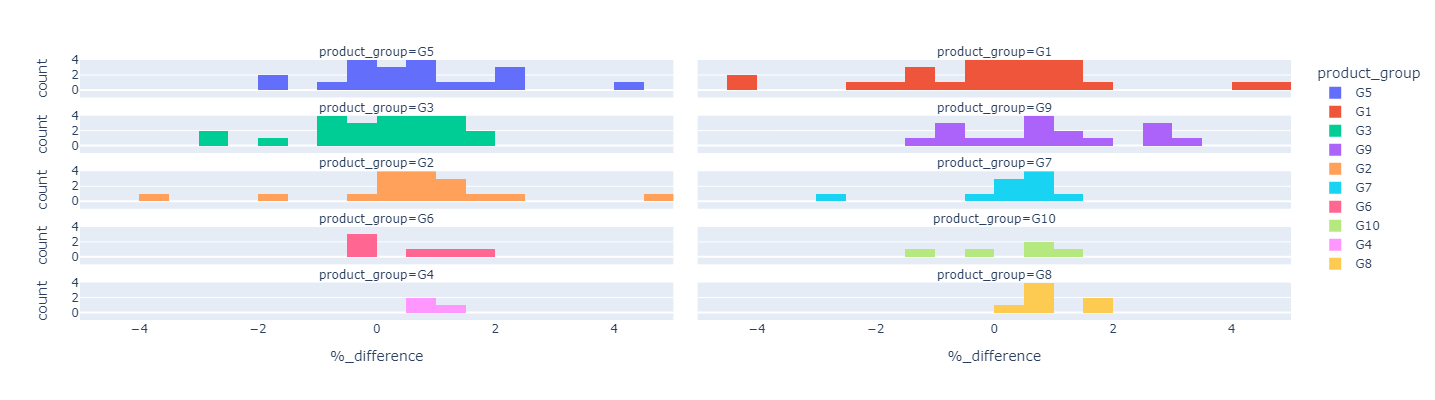

In [134]:
bin_width= 0.5           
nbins = math.ceil((allprod_results_df["%_difference"].max() - allprod_results_df["%_difference"].min()) / bin_width)
fig = px.histogram(allprod_results_df, x='%_difference', nbins = nbins, color = 'product_group', 
                   facet_col = 'product_group', facet_col_wrap = 2, height = 400, range_x =(-5, 5))
fig.show()

### Getting the no. of products with confilicting/supporting regression trends with low and high observations

In [135]:
allprod_results_df_left['no_obs'] = np.where(allprod_results_df_left['rows']>=10, '>=10', '<10')
stats_df = allprod_results_df_left.groupby(['no_obs','slope_dir_comparison']).count().reset_index()
stats_df = stats_df[['no_obs','slope_dir_comparison','product']]
stats_df

no_obs slope_dir_comparison  product
0    <10  different_direction       38
1    <10       same_direction       29
2   >=10  different_direction        4
3   >=10       same_direction      140

## Uncertainty Graph

In [139]:
def regression_vs_bayesian_prod_scatterplot_uncertainty3(productname, data, reg_results, bayesian_reg_dict_results):
    data1 = data.loc[data['product']== productname].sort_values('period').reset_index(drop=True)
    #prodgroup = data1['product_group'].values[0]
    
    #plotting the npi values
    trace1 = px.scatter(data1, x = "period_index", y = "npi", title = productname)
    trace1.update_traces(name='Original NPI', showlegend = True)
    trace1.update_traces(marker=dict(color='blue'))
    
    #plotting the ordinary regression line
    regression_results_filtered = reg_results.loc[reg_results['Product'] == productname]
    intercept = regression_results_filtered['Intercept'].values[0]
    slope = regression_results_filtered['Slope'].values[0]
    df_product_regress = pd.DataFrame()
    df_product_regress['x'] = data1["period_index"]
    df_product_regress['y'] = slope*df_product_regress['x']+intercept
    
    # Add uncertainty to ordinary regression line
    y_pred_ordinary = slope * df_product_regress['x'] + intercept
    stderr_ordinary = np.std(data1["npi"] - y_pred_ordinary)
    df_product_regress['upper_ordinary'] = y_pred_ordinary + 1.96 * stderr_ordinary
    df_product_regress['lower_ordinary'] = y_pred_ordinary - 1.96 * stderr_ordinary
    
    #plotting the bayesian regression line
    bayesian_reg_results_filtered = pm.summary(bayesian_reg_dict_results[productname])
    trace2 = px.line(df_product_regress, df_product_regress['x'], df_product_regress['y'], color_discrete_sequence=['blue'])
    trace2.update_traces(name='Ordinary Regression', showlegend = True)
    intercept2 = bayesian_reg_results_filtered['mean'].loc['intercept']
    slope2 = bayesian_reg_results_filtered['mean'].loc['slope']
    df_productgroup_regress = pd.DataFrame()
    df_productgroup_regress['x'] = data1["period_index"]
    df_productgroup_regress['y'] = slope2*df_productgroup_regress['x']+intercept2
    trace3 = px.line(df_productgroup_regress, df_productgroup_regress['x'], df_productgroup_regress['y'], color_discrete_sequence=['purple'])
    trace3.update_traces(name='Bayesian Regression', showlegend = True)
    
    # Add uncertainty to Bayesian regression line
    y_pred_bayesian = slope2 * df_productgroup_regress['x'] + intercept2
    #pm.plot_posterior_predictive_glm(bayesian_reg_dict_results[productname], samples=1000, eval=np.linspace(0, len(df_productgroup_regress['x']), len(df_productgroup_regress['x'])), color='purple', alpha=0.2)
    bayesian_results = pm.summary(bayesian_reg_dict_results[productname])
    df_productgroup_regress['upper_bayesian'] = y_pred_bayesian + 1.96 * bayesian_results['sd'].loc['slope']
    df_productgroup_regress['lower_bayesian'] = y_pred_bayesian - 1.96 * bayesian_results['sd'].loc['slope']

    fig = px.scatter(data1, x="period_index", y="npi", title=productname)
    fig.add_scatter(x=df_product_regress['x'], y=df_product_regress['y'], mode='lines', line=dict(color='blue'), name='Ordinary Regression')
    fig.add_scatter(x=df_product_regress['x'], y=df_product_regress['upper_ordinary'], mode='lines', line=dict(color='grey', dash='dash'), name='Ordinary Regression Upper CI', fillcolor='rgba(169,169,169,0.2)')
    fig.add_scatter(x=df_product_regress['x'], y=df_product_regress['lower_ordinary'], mode='lines', line=dict(color='grey', dash='dash'), name='Ordinary Regression Lower CI', fillcolor='rgba(169,169,169,0.2)')
    fig.add_scatter(x=df_productgroup_regress['x'], y=y_pred_bayesian, mode='lines', line=dict(color='purple'), name='Bayesian Regression')
    fig.add_scatter(x=df_productgroup_regress['x'], y=df_productgroup_regress['upper_bayesian'], mode='lines', line=dict(color='pink', dash='dash'), name='Bayesian Regression Upper CI', fillcolor='rgba(255,105,180,0.2)')
    fig.add_scatter(x=df_productgroup_regress['x'], y=df_productgroup_regress['lower_bayesian'], mode='lines', line=dict(color='pink', dash='dash'), name='Bayesian Regression Lower CI', fillcolor='rgba(255,105,180,0.2)')
    fig.show()
    